Below is the original prompt I gave to GPT-4, although most of what is here now was added with further prompts and by hand.

> I want to create a Jupyter notebook that visualises the weights of a neural network trained on the MNIST dataset. I would like to train the neural network myself using the PyTorch framework. I want the neural network to have one hidden layer of 15 units. I want to visualise the weights of each feature in the hidden layer as heat maps on the same plot, and the weights going from the last hidden layer to the output layer as a single heat map, with the axis corresponding to the number labeled. Assume I have already installed the necessary libraries.

In [1]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Define the neural network architecture
class Net(nn.Module):
    def __init__(self, num_units, activation):
        super(Net, self).__init__()
        self.activation = activation
        self.fc1 = nn.Linear(28 * 28, num_units)
        self.fc2 = nn.Linear(num_units, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)

        return x

In [4]:
def train_network(num_units=15, activation='sigmoid', num_epochs=10):
    # Initialize the model
    model = Net(num_units, activation).to(device)

    # Define the loss function and optimizer
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=1e-2)

    # Load the training data
    mnist_data_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
    train_loader = torch.utils.data.DataLoader(dataset=mnist_data_train, batch_size=64, shuffle=True)

    # Load the validation data
    mnist_data_val = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
    val_loader = torch.utils.data.DataLoader(dataset=mnist_data_val, batch_size=64, shuffle=False)

    # Training the network
    for epoch in range(num_epochs):
        for images, labels in train_loader:
            # Move tensors to the configured device
            images = images.reshape(-1, 28 * 28).to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = loss_function(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Validate the model
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.reshape(-1, 28 * 28).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Training completed!')
    print('Accuracy of the model on the validation images: {}%'.format(100 * correct / total))

    return model

In [5]:
def plot_weights(model, *, output_units=None):
    # Visualize the weights
    def plot_heatmap(weights, fig, ax, title, *, xticks=None, yticks=None, xlabel=None, ylabel=None):
        im = ax.imshow(weights, cmap='RdBu')
        ax.set_title(title)

        if xticks is not None:
            ax.set_xticks(xticks)
        if yticks is not None:
            ax.set_yticks(yticks)
        if xlabel is not None:
            ax.set_xlabel(xlabel)
        if ylabel is not None:
            ax.set_ylabel(ylabel)

        fig.colorbar(im, ax=ax)

    # Get the weights of the input to the hidden layer
    weights1 = model.fc1.weight.data.cpu().numpy()

    # Determine the grid size for plotting hidden layer units
    grid_size = int(np.ceil(np.sqrt(weights1.shape[0])))

    # Plot the weights of hidden layer as grid_size x grid_size heatmaps
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(16, 16))

    for i in range(grid_size):
        for j in range(grid_size):
            if i*grid_size + j < weights1.shape[0]: # To make sure we don't go out of bounds
                plot_heatmap(weights1[i*grid_size + j, :].reshape(28, 28), fig, axs[i, j], f'Hidden Layer Unit {i*grid_size + j}')
            else:
                axs[i, j].axis('off') # Turn off the axis for the plots with no data

    plt.tight_layout()
    plt.show()
    plt.close() # Close the plot to free up memory

    # Get the weights of the hidden layer to the output
    weights2 = model.fc2.weight.data.cpu().numpy()

    # Determine which output units to show
    if output_units is None:
        output_units = list(range(weights2.shape[0])) # Default to all output units

    # Plot the weights of output layer
    fig, axs = plt.subplots(1, len(output_units), figsize=(4 * len(output_units), 10))
    for i, output_unit in enumerate(output_units):
        plot_heatmap(weights2[output_unit,:].reshape(-1, 1), fig, axs[i], f'Hidden Layer Units to Output {output_unit}', xticks=(), yticks=range(weights2.shape[1]), ylabel='Hidden Units', xlabel=f'Output {output_unit}')
    plt.tight_layout()
    plt.show()
    plt.close() # Close the plot to free up memory

Training completed!
Accuracy of the model on the validation images: 84.78%


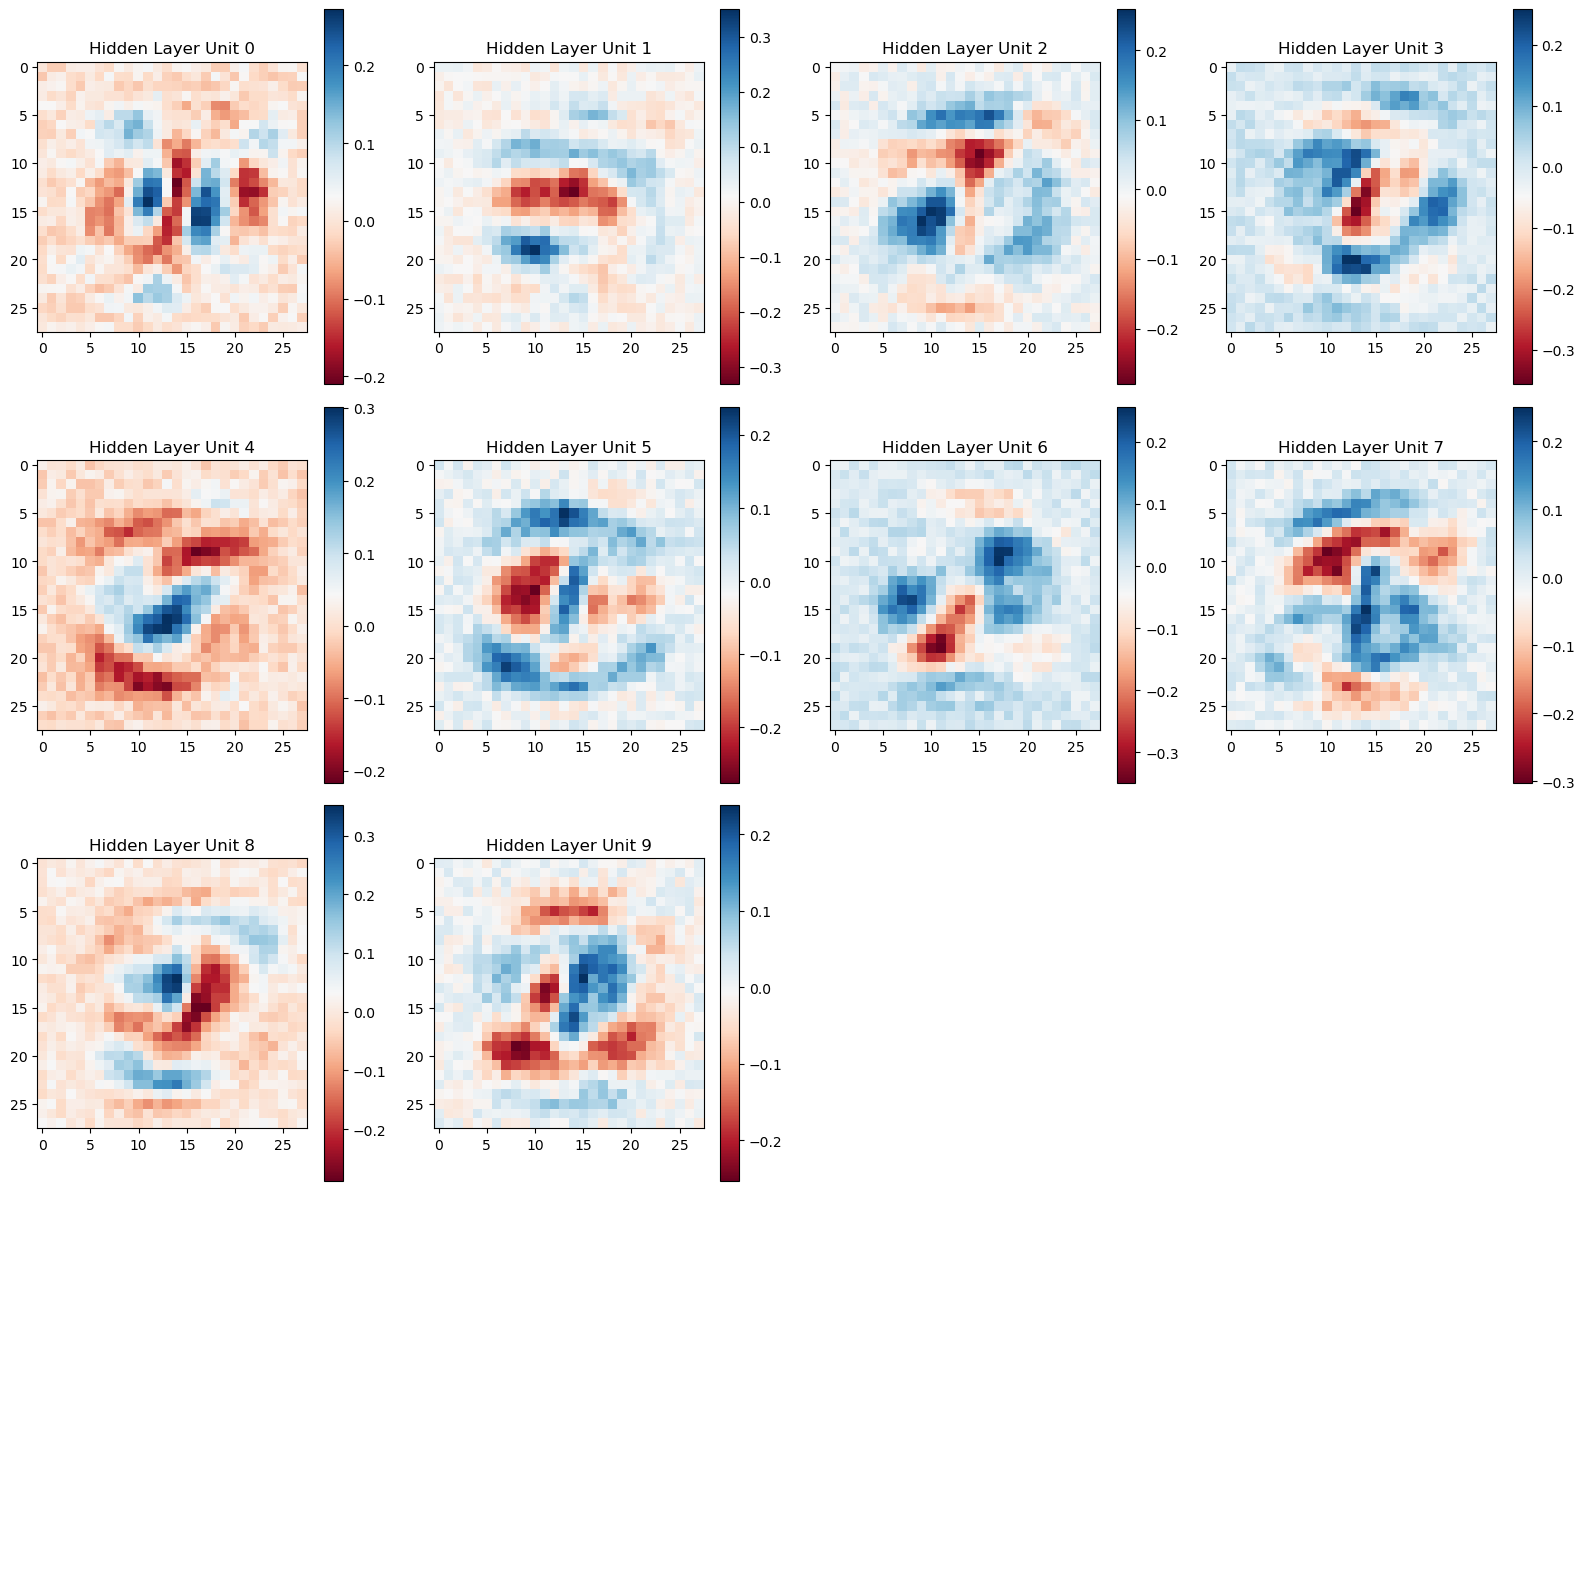

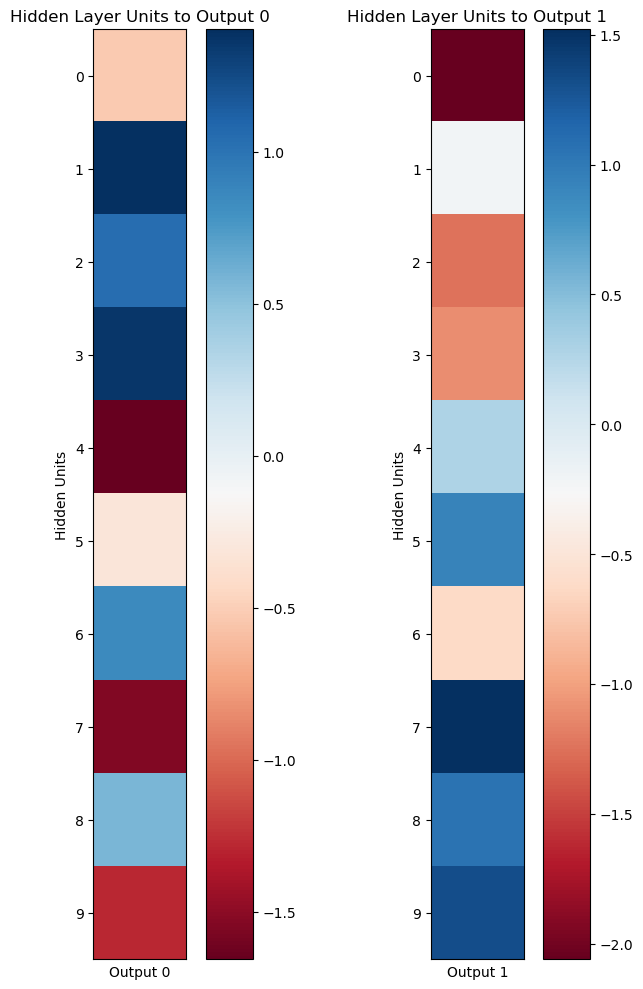

In [6]:
# num_units=10, activation=torch.sigmoid, num_epochs=10
model_10_sigmoid_10 = train_network(num_units=10, activation=torch.sigmoid, num_epochs=10)
plot_weights(model_10_sigmoid_10, output_units=[0, 1])

Training completed!
Accuracy of the model on the validation images: 91.42%


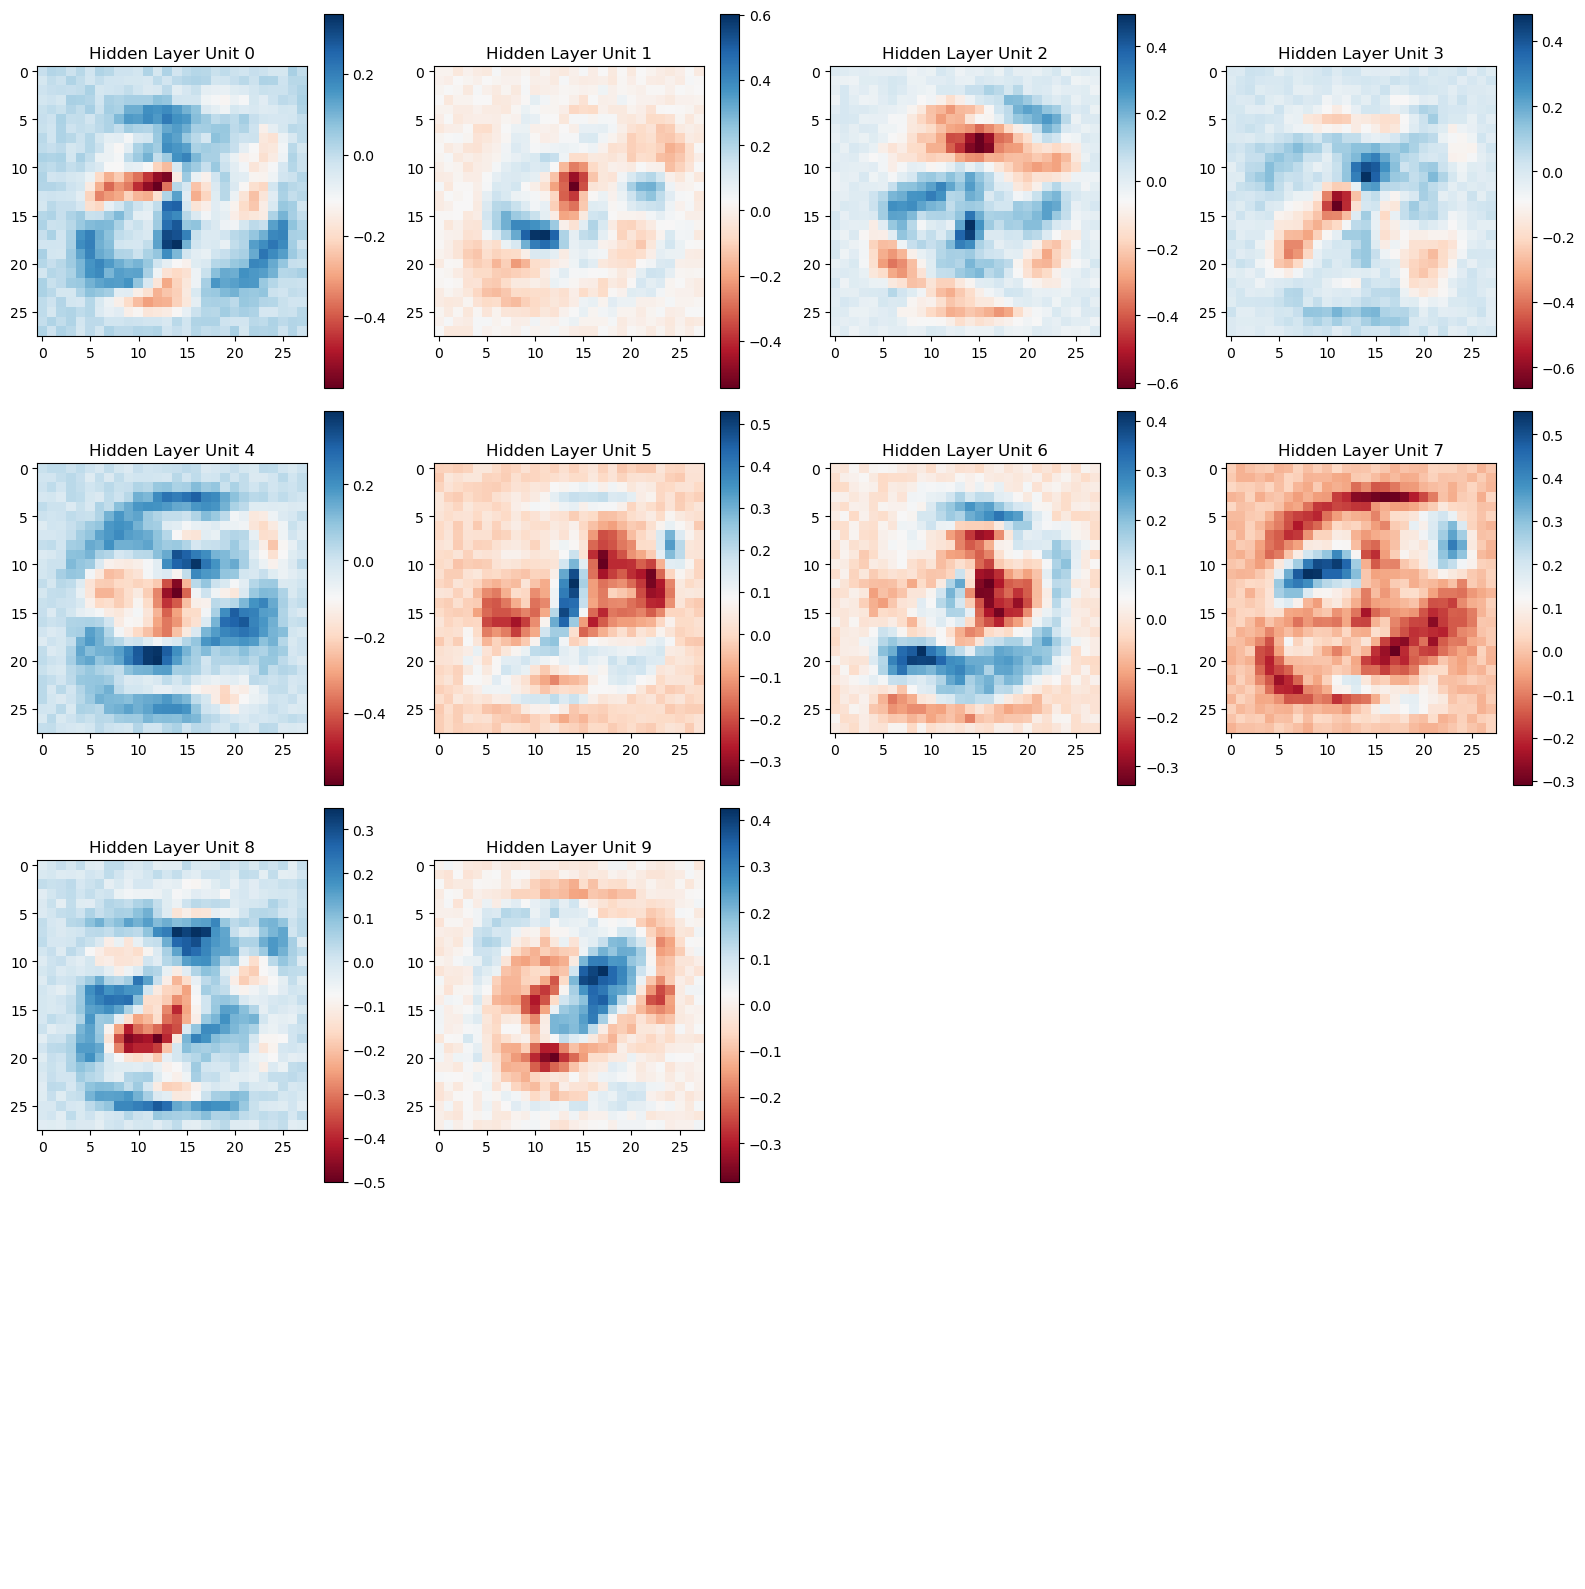

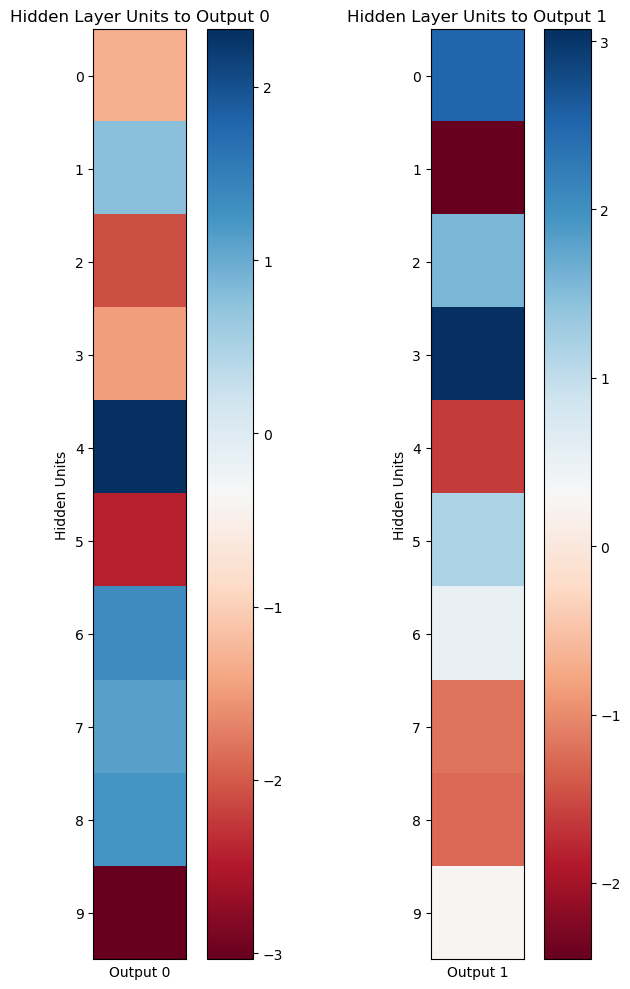

In [7]:
# num_units=10, activation=torch.sigmoid, num_epochs=50
model_10_sigmoid_50 = train_network(num_units=10, activation=torch.sigmoid, num_epochs=50)
plot_weights(model_10_sigmoid_50, output_units=[0, 1])

Training completed!
Accuracy of the model on the validation images: 91.78%


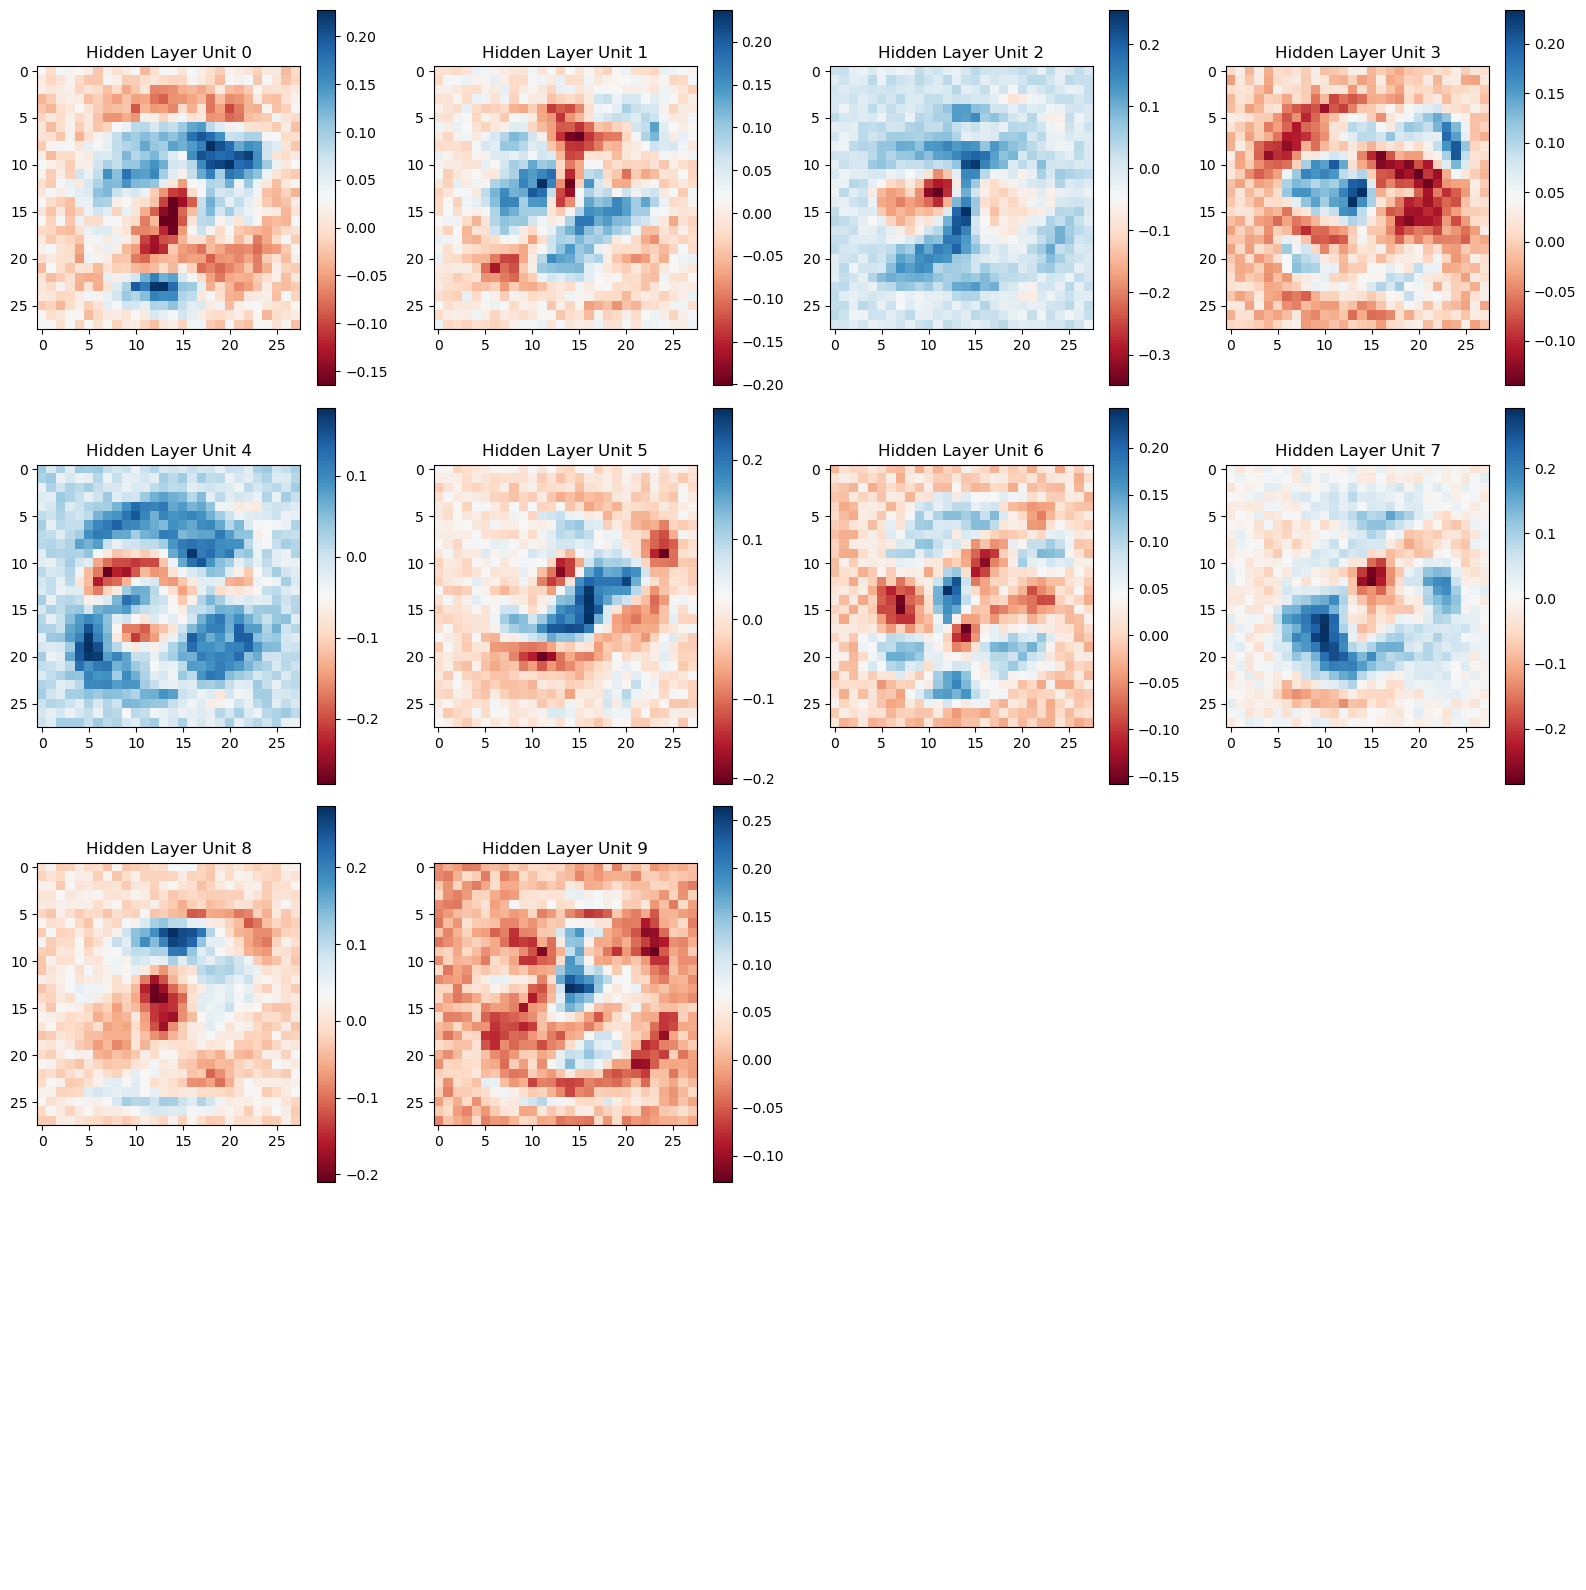

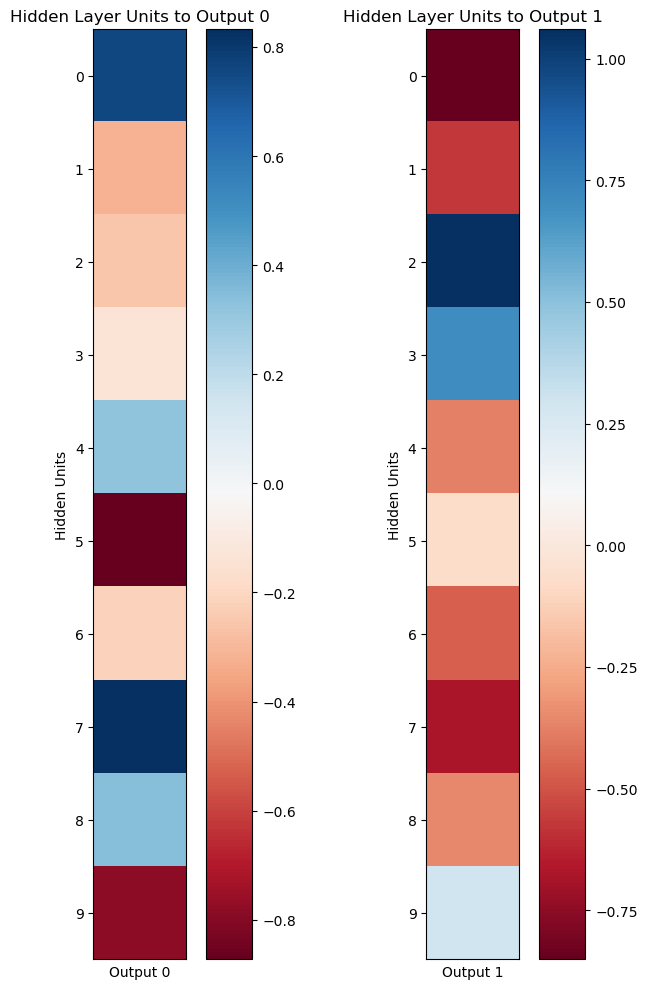

In [8]:
# num_units=10, activation=torch.nn.ReLU(), num_epochs=10
model_10_relu_10 = train_network(num_units=10, activation=torch.nn.ReLU(), num_epochs=10)
plot_weights(model_10_relu_10, output_units=[0, 1])

Training completed!
Accuracy of the model on the validation images: 93.34%


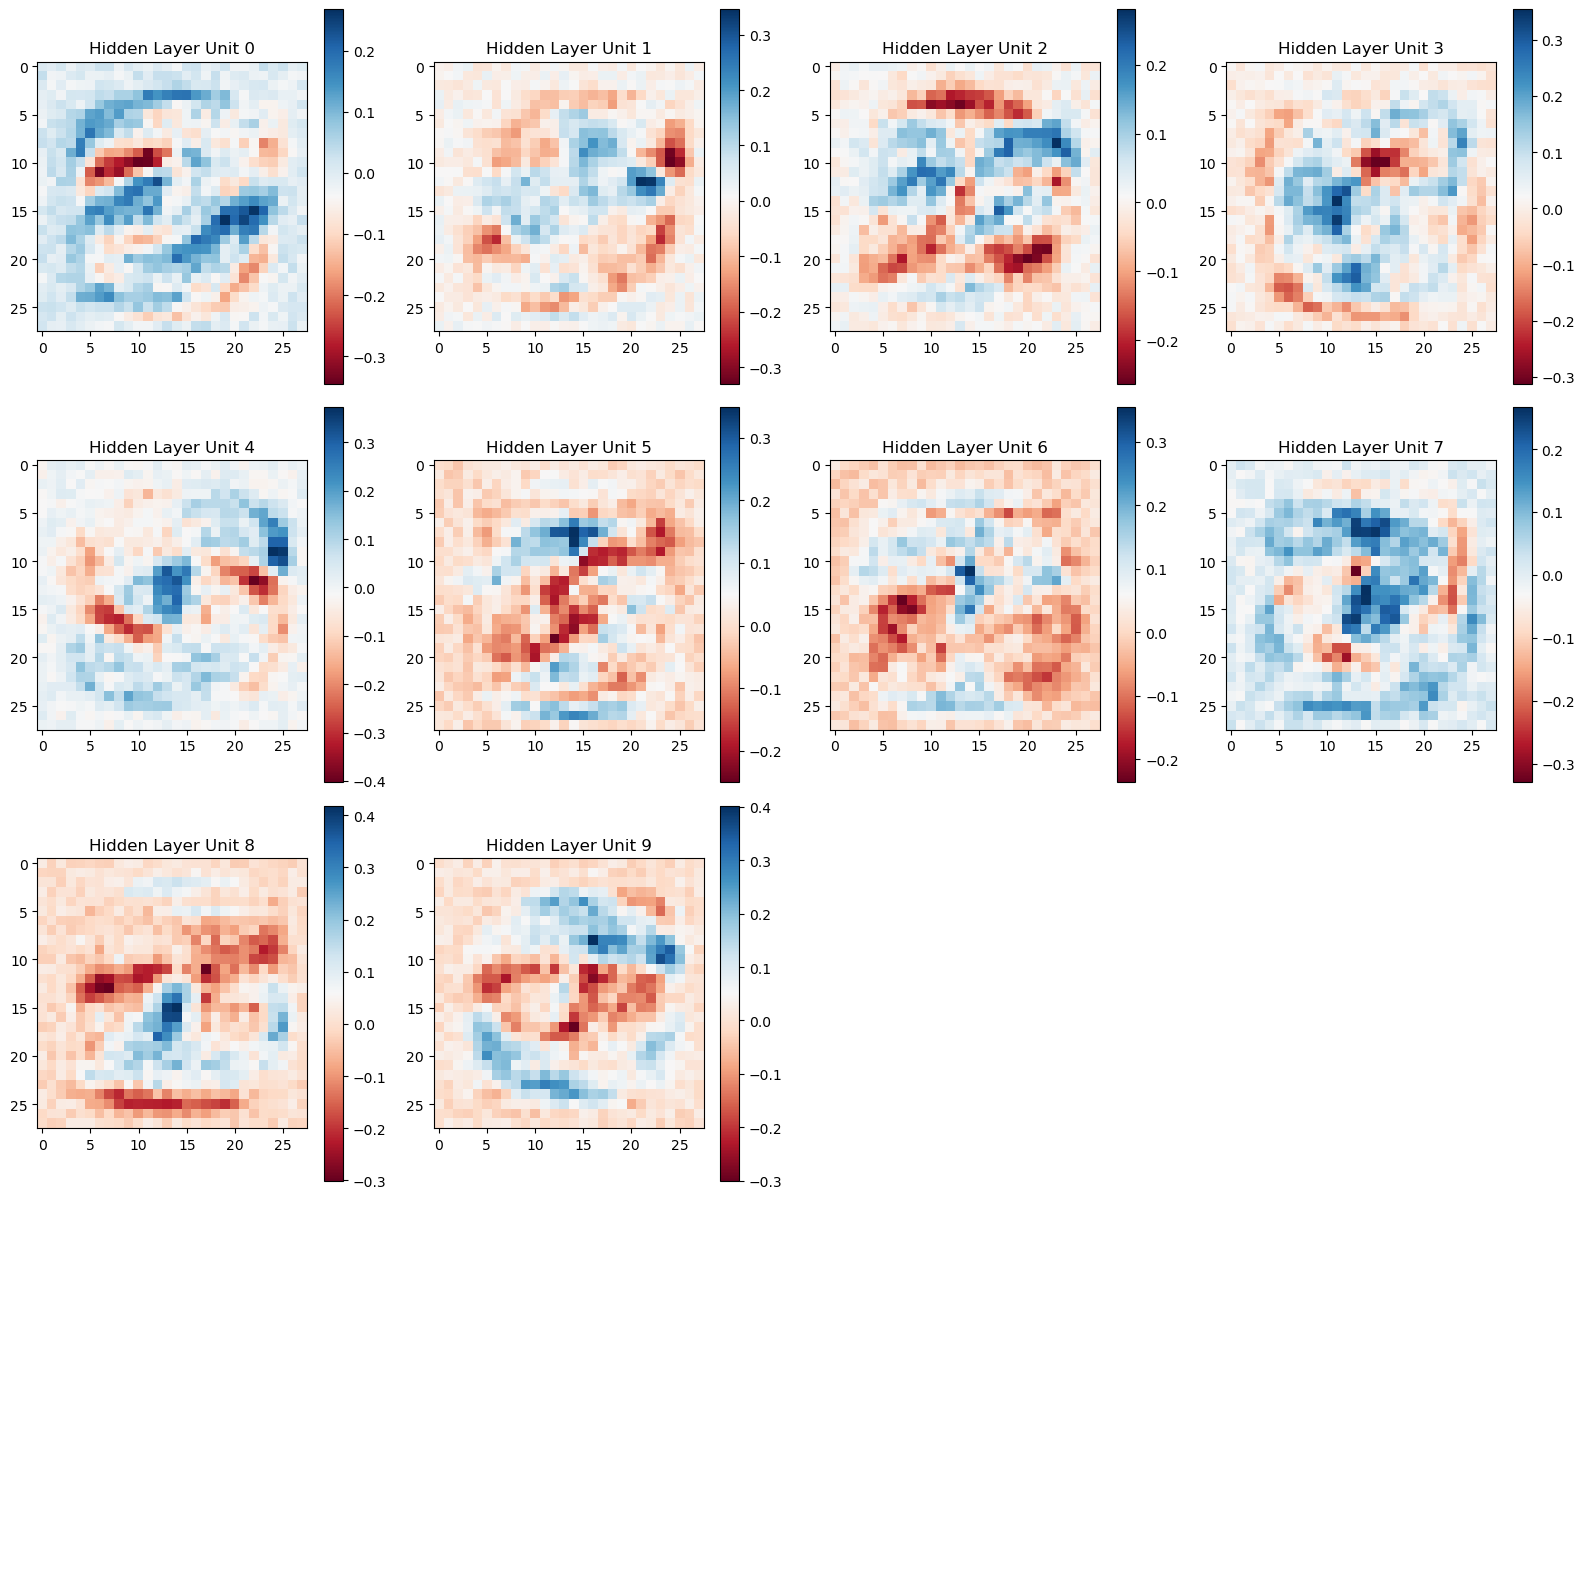

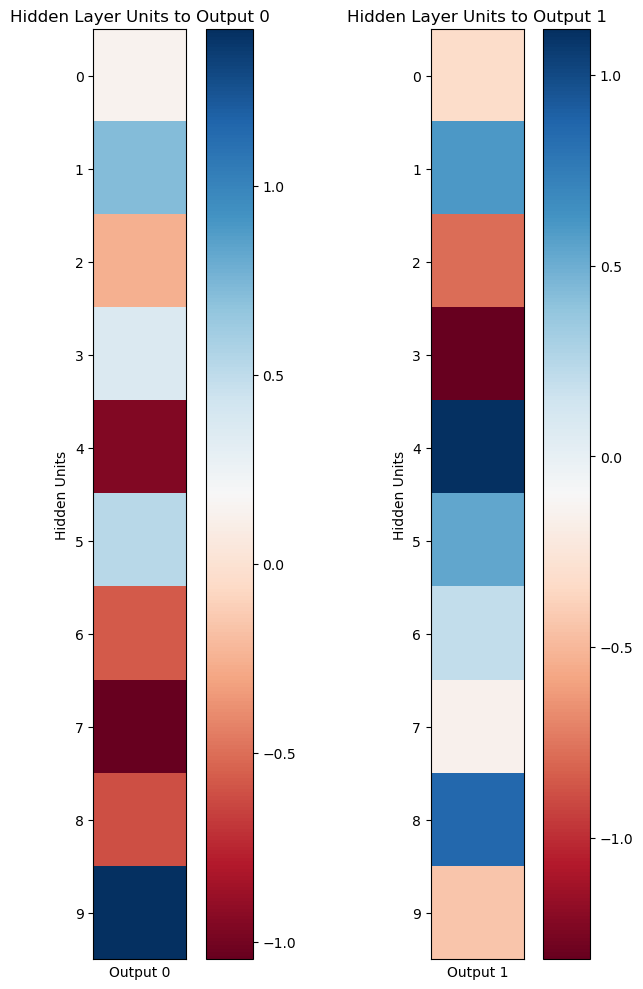

In [9]:
# num_units=10, activation=torch.nn.ReLU(), num_epochs=50
model_10_relu_50 = train_network(num_units=10, activation=torch.nn.ReLU(), num_epochs=50)
plot_weights(model_10_relu_50, output_units=[0, 1])

Training completed!
Accuracy of the model on the validation images: 87.38%


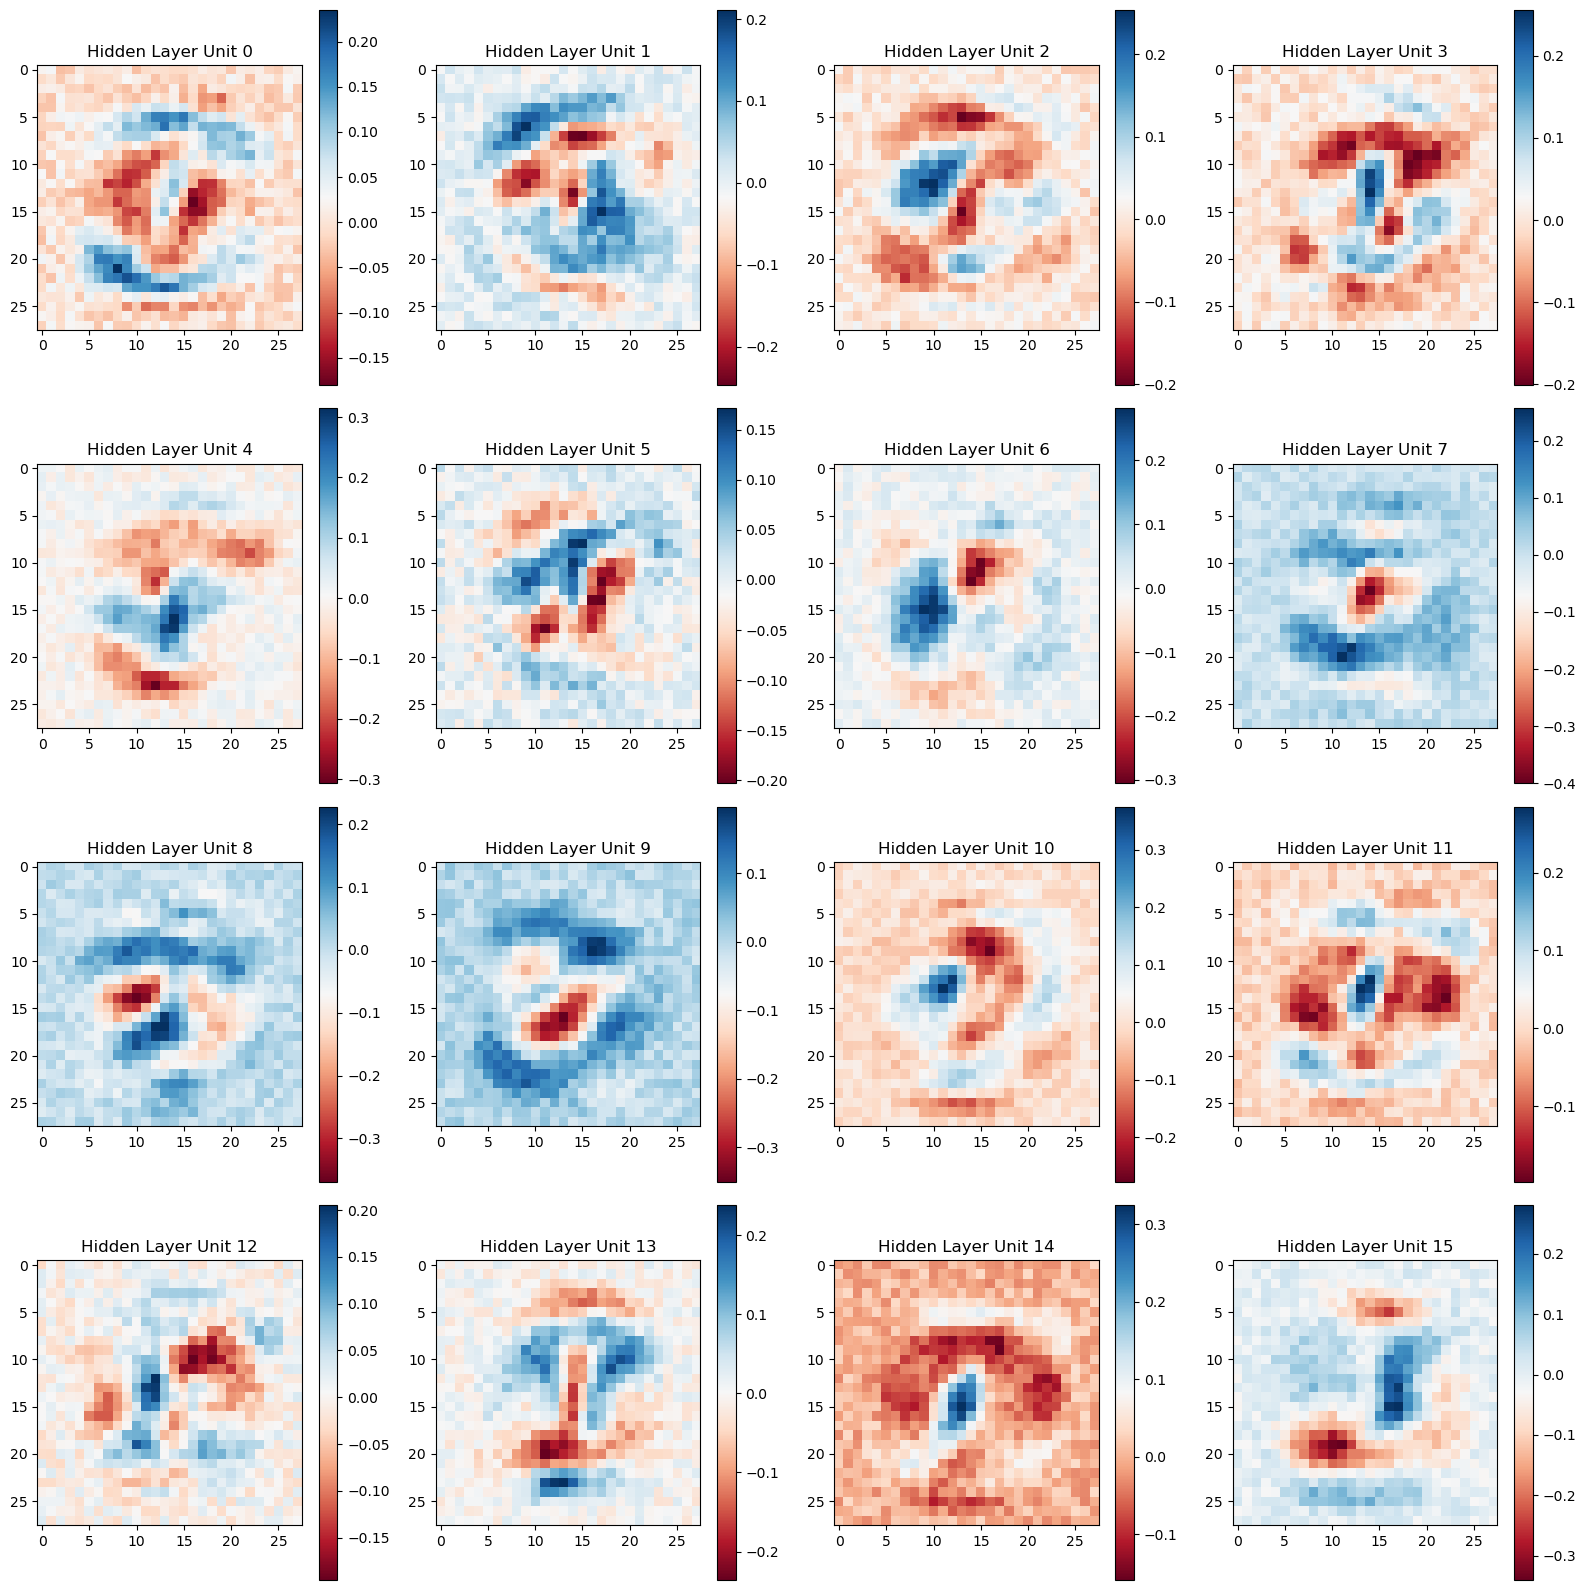

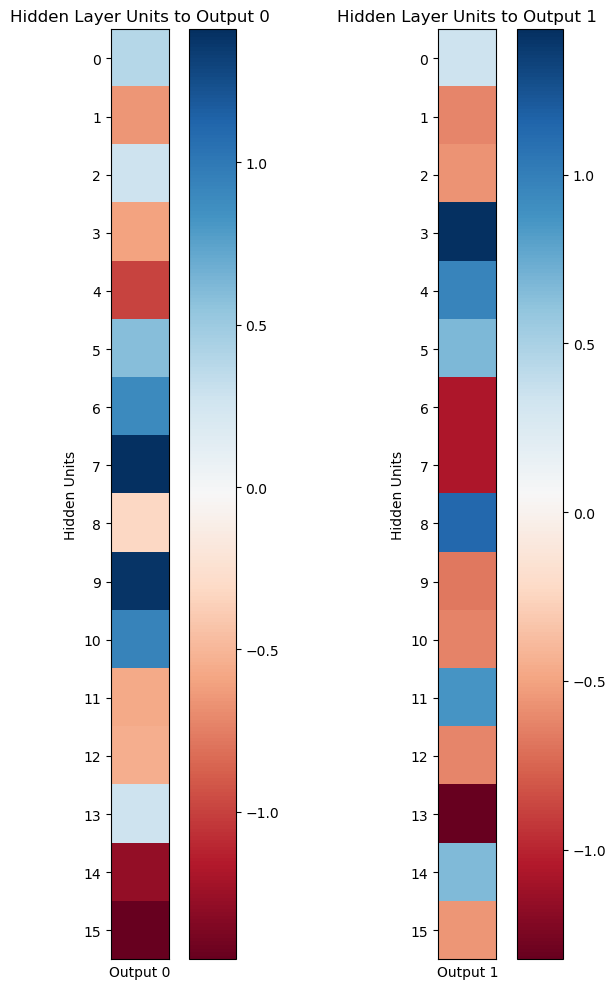

In [10]:
# num_units=16, activation=torch.sigmoid, num_epochs=10
model_16_sigmoid_10 = train_network(num_units=16, activation=torch.sigmoid, num_epochs=10)
plot_weights(model_16_sigmoid_10, output_units=[0, 1])

Training completed!
Accuracy of the model on the validation images: 92.58%


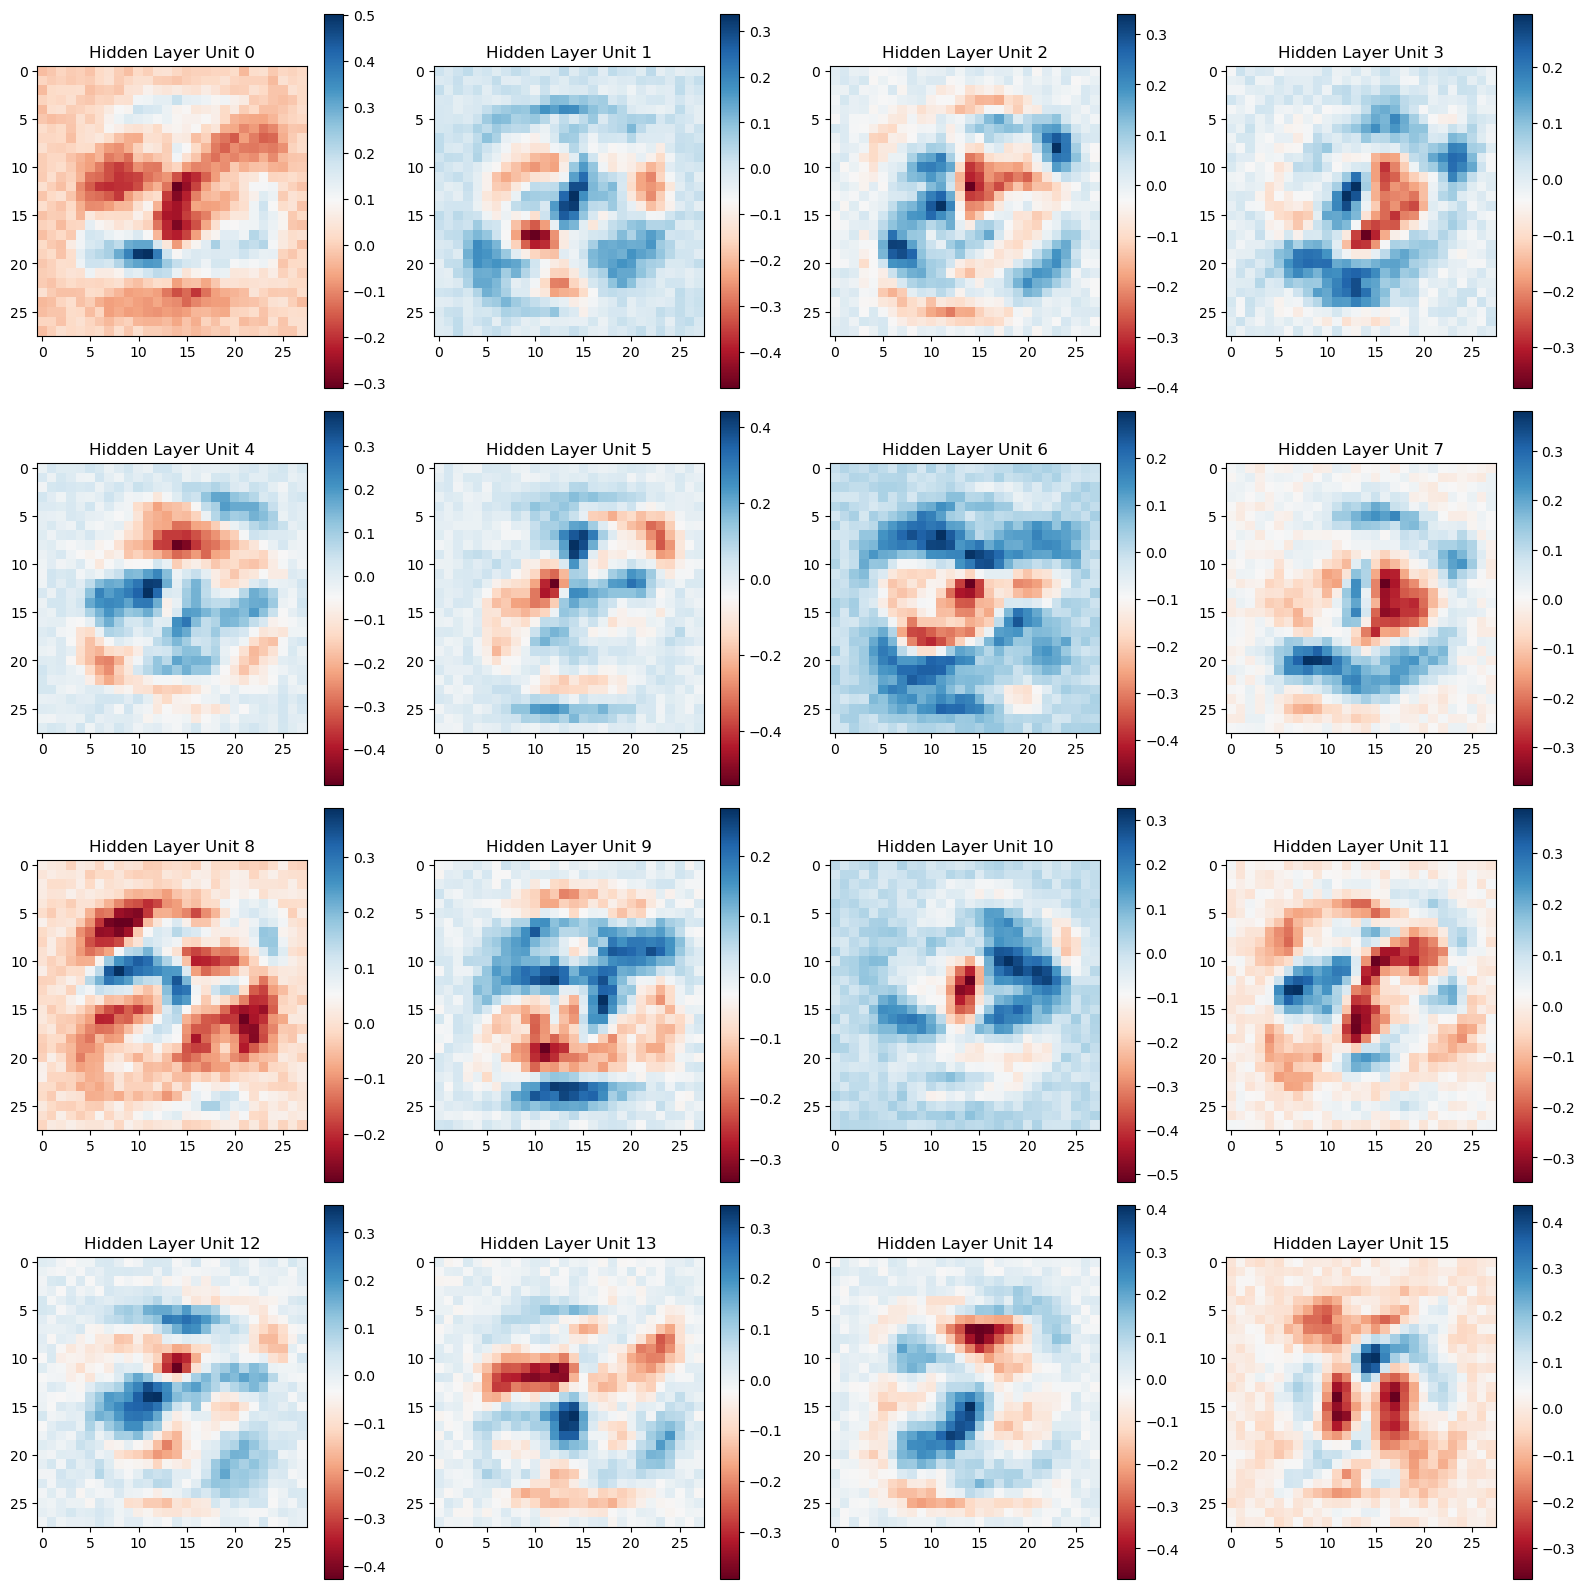

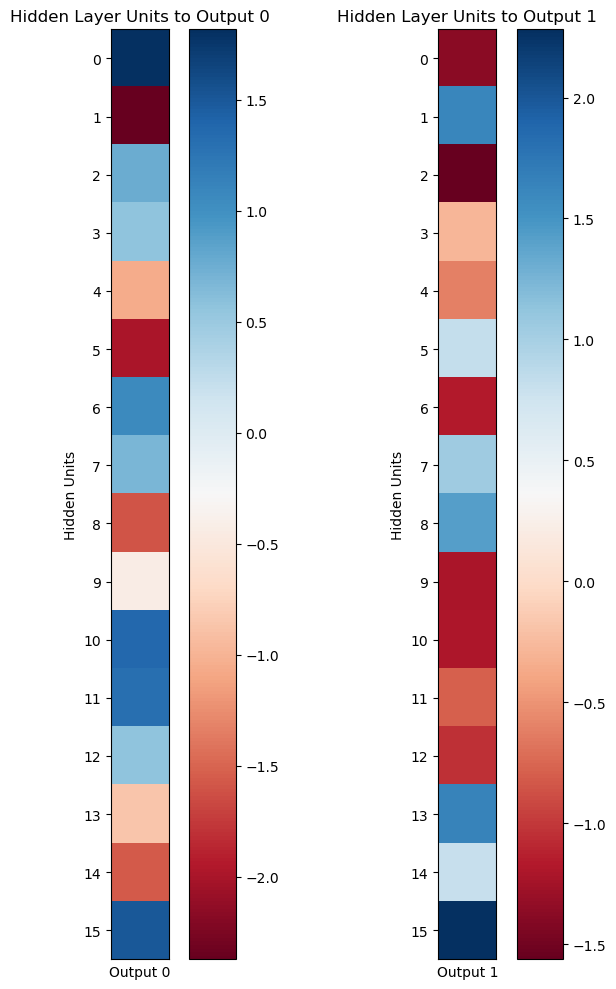

In [11]:
# num_units=16, activation=torch.sigmoid, num_epochs=50
model_16_sigmoid_50 = train_network(num_units=16, activation=torch.sigmoid, num_epochs=50)
plot_weights(model_16_sigmoid_50, output_units=[0, 1])

Training completed!
Accuracy of the model on the validation images: 92.48%


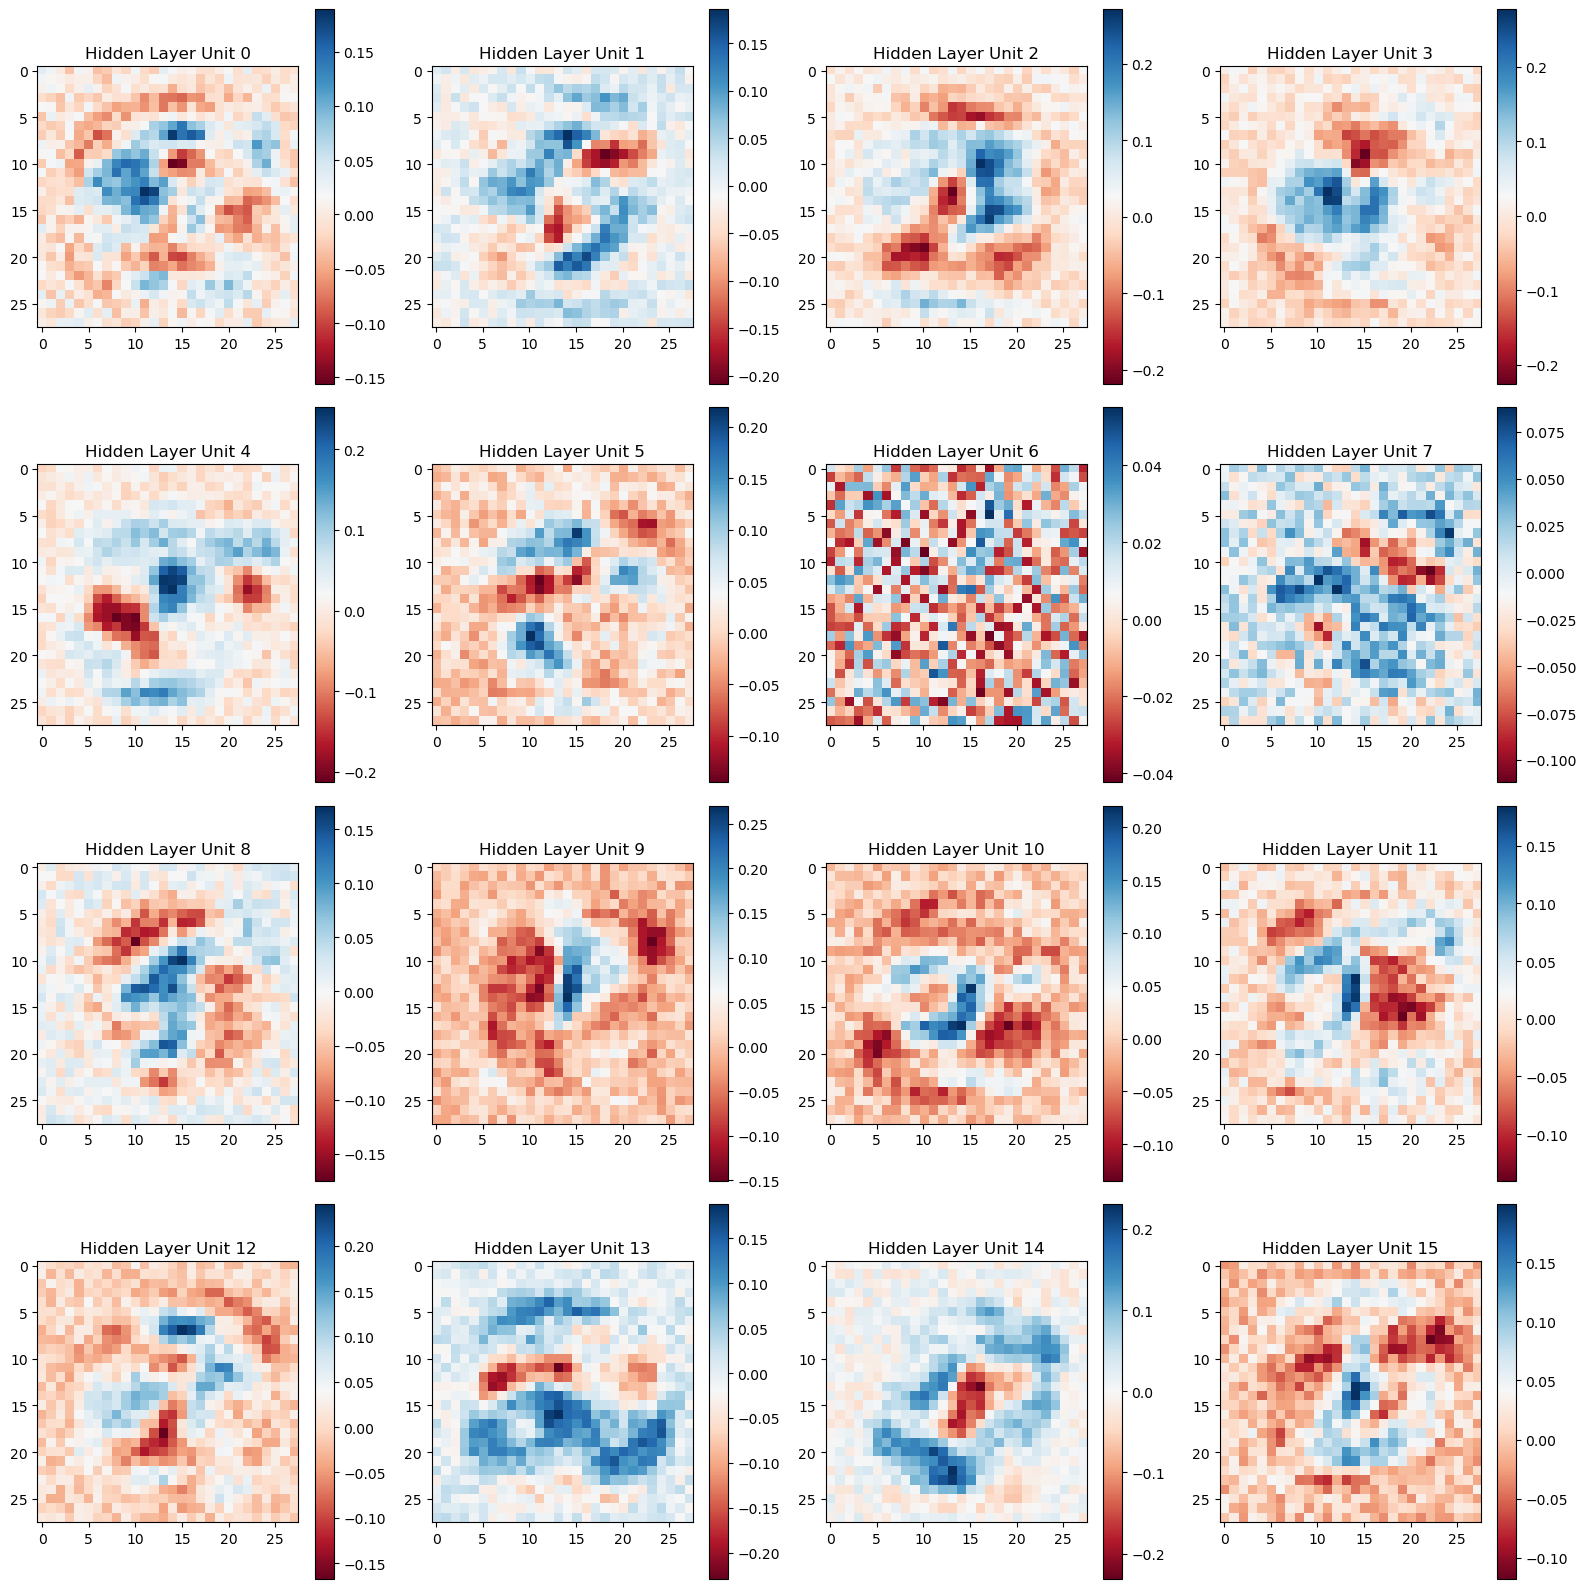

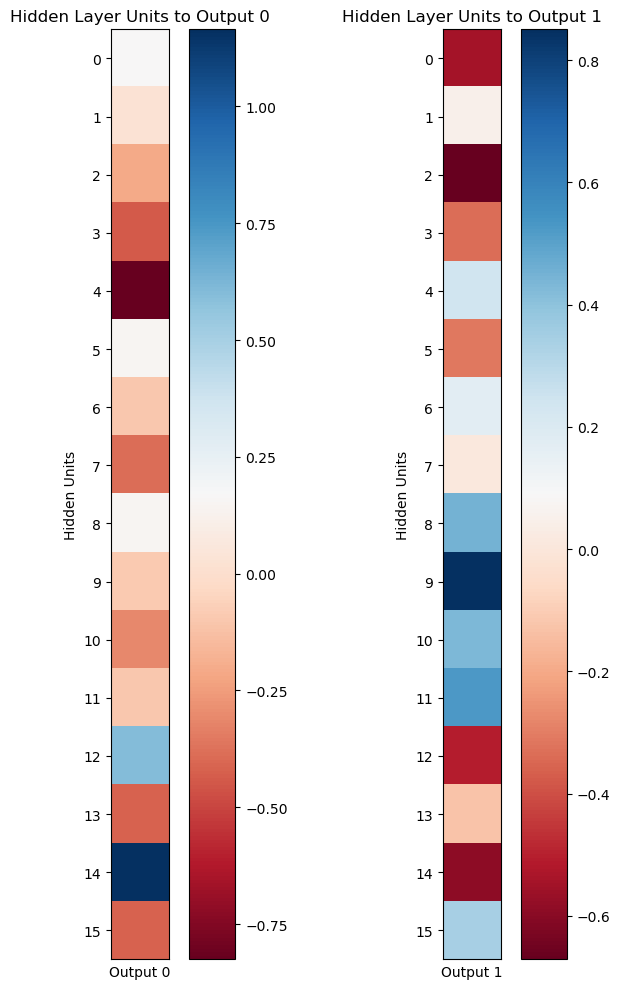

In [12]:
# num_units=16, activation=torch.nn.ReLU(), num_epochs=10
model_16_relu_10 = train_network(num_units=16, activation=torch.nn.ReLU(), num_epochs=10)
plot_weights(model_16_relu_10, output_units=[0, 1])

Training completed!
Accuracy of the model on the validation images: 94.52%


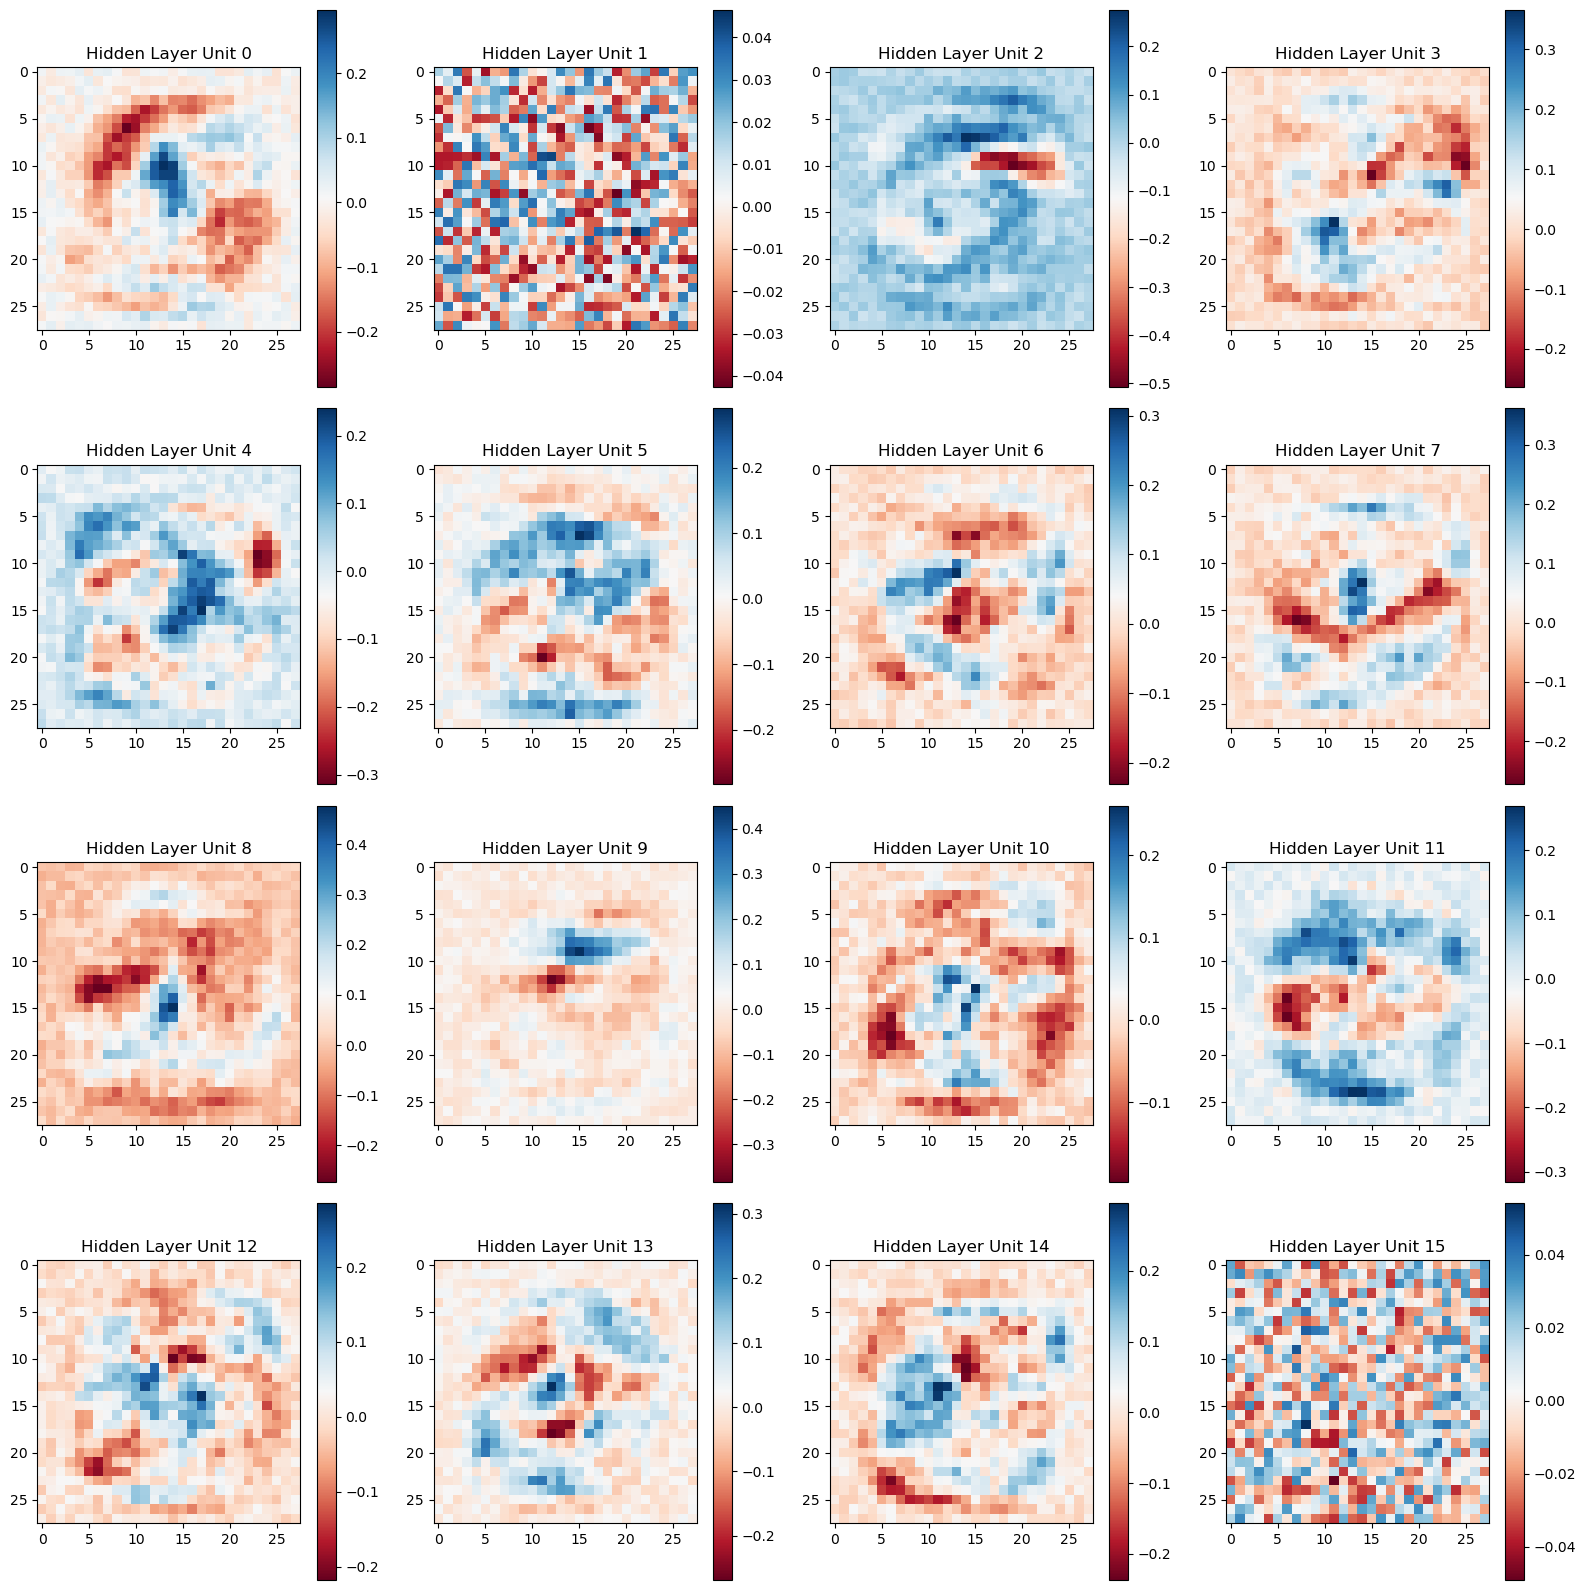

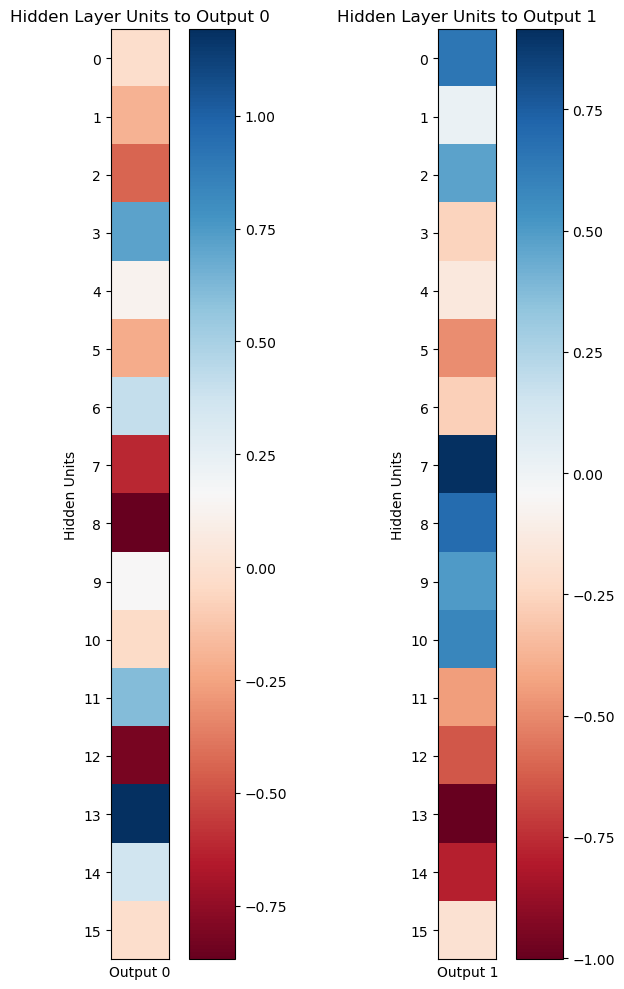

In [13]:
# num_units=16, activation=torch.nn.ReLU(), num_epochs=50
model_16_relu_50 = train_network(num_units=16, activation=torch.nn.ReLU(), num_epochs=50)
plot_weights(model_16_relu_50, output_units=[0, 1])

Training completed!
Accuracy of the model on the validation images: 88.45%


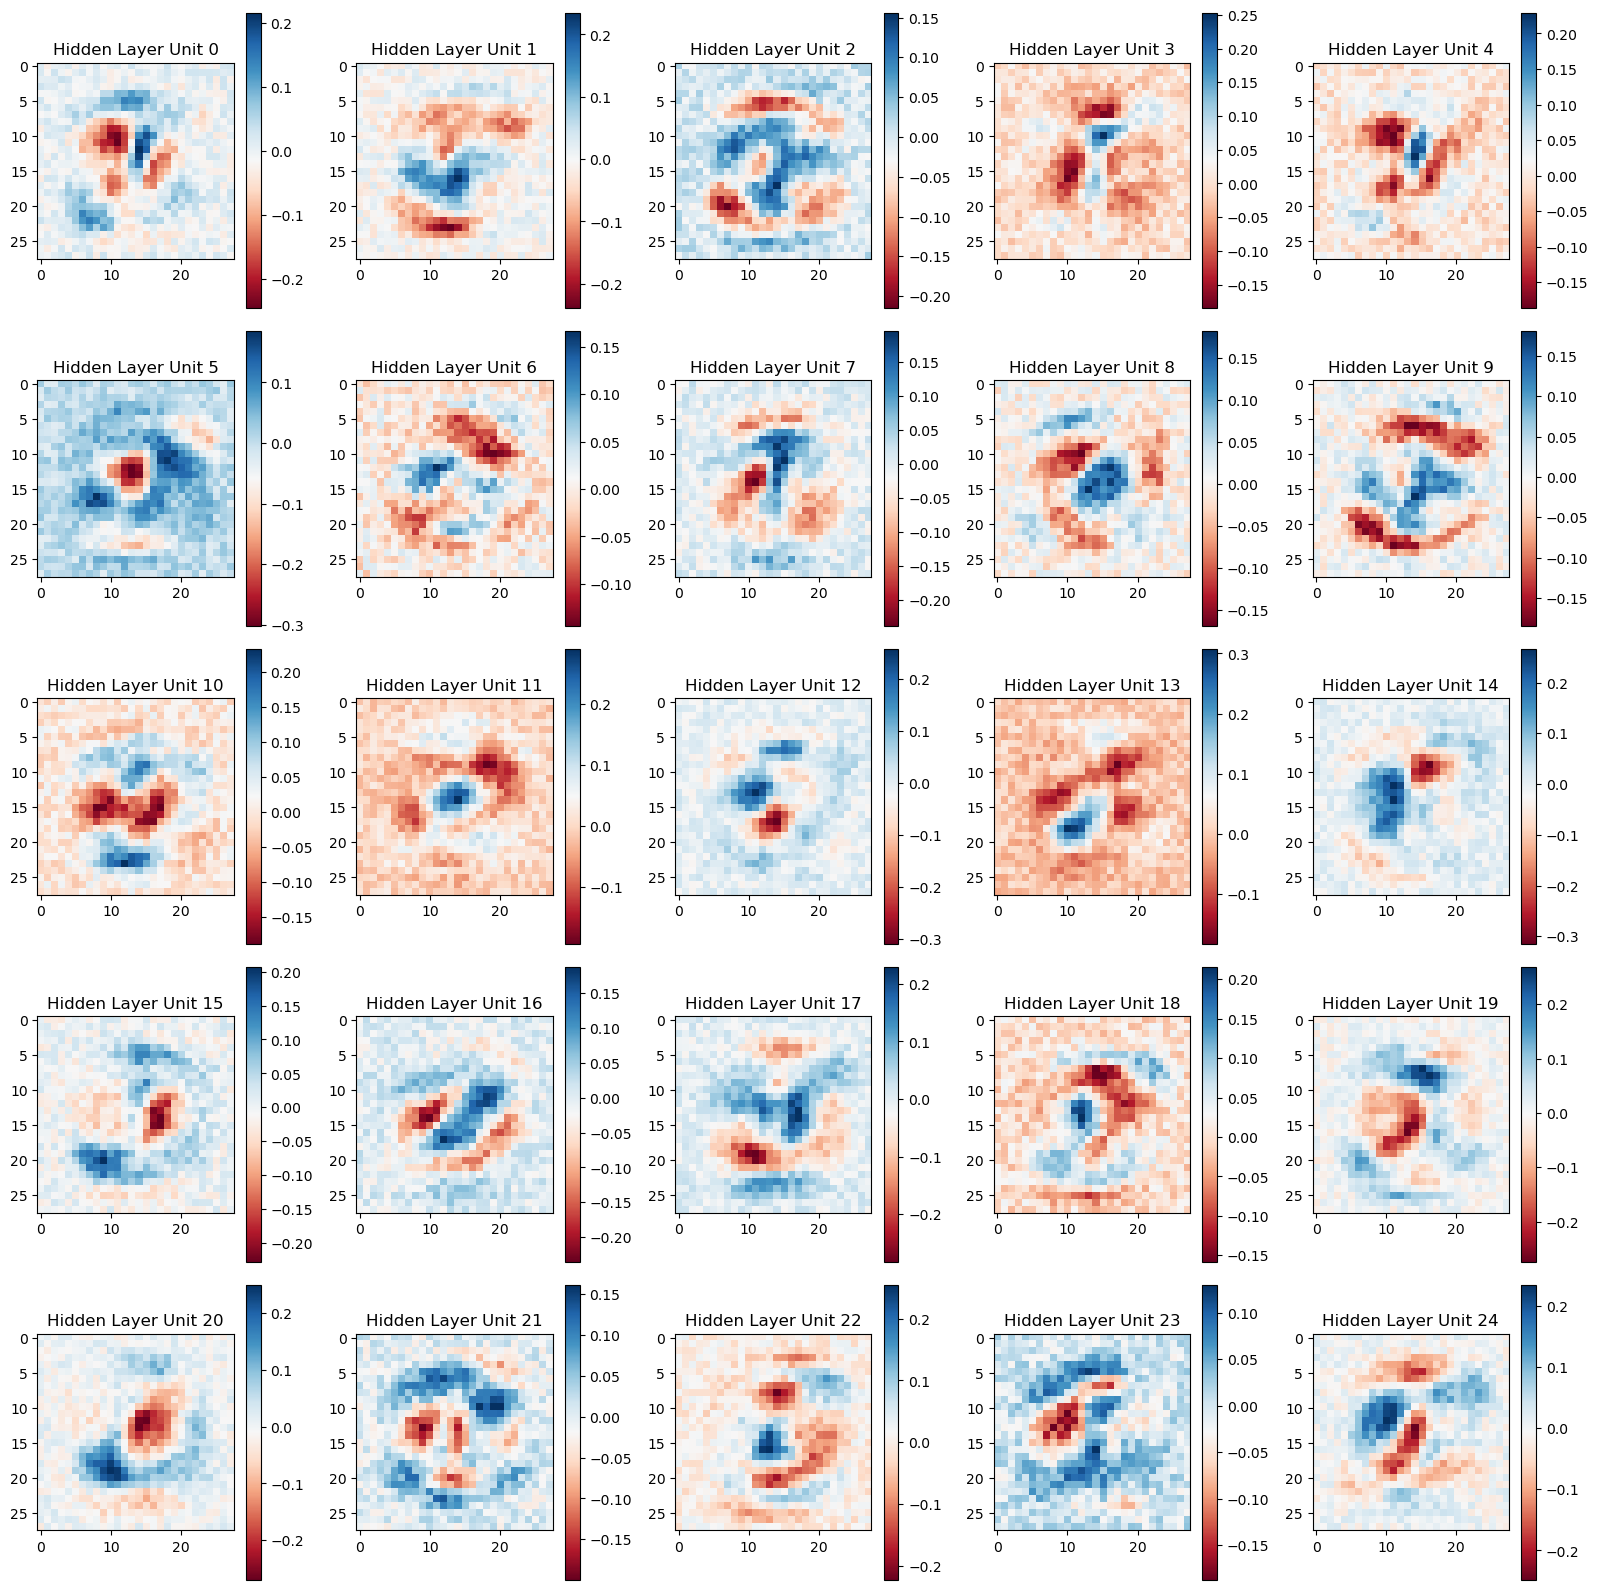

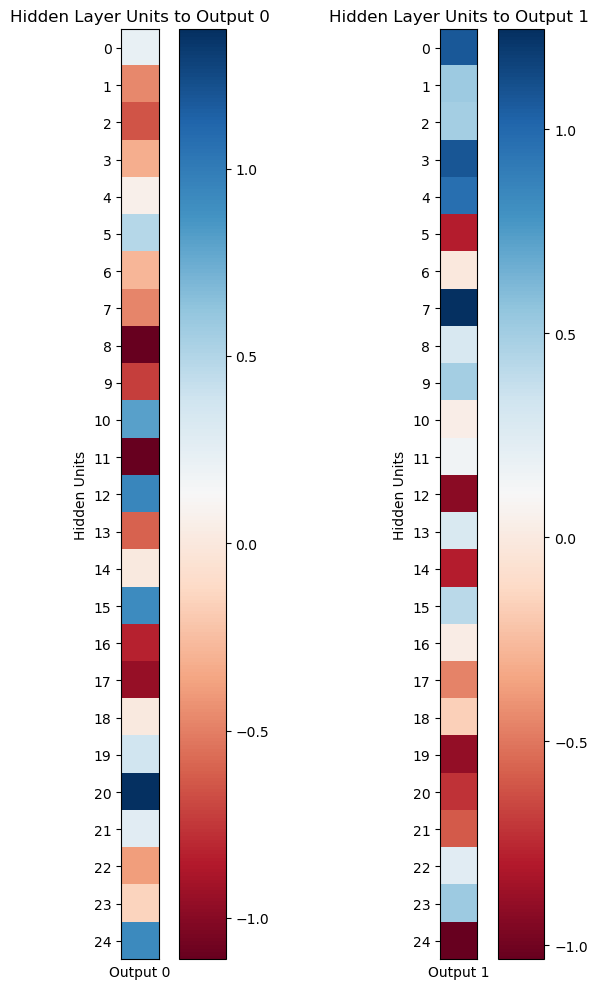

In [14]:
# num_units=25, activation=torch.sigmoid, num_epochs=10
model_25_sigmoid_10 = train_network(num_units=25, activation=torch.sigmoid, num_epochs=10)
plot_weights(model_25_sigmoid_10, output_units=[0, 1])

Training completed!
Accuracy of the model on the validation images: 93.02%


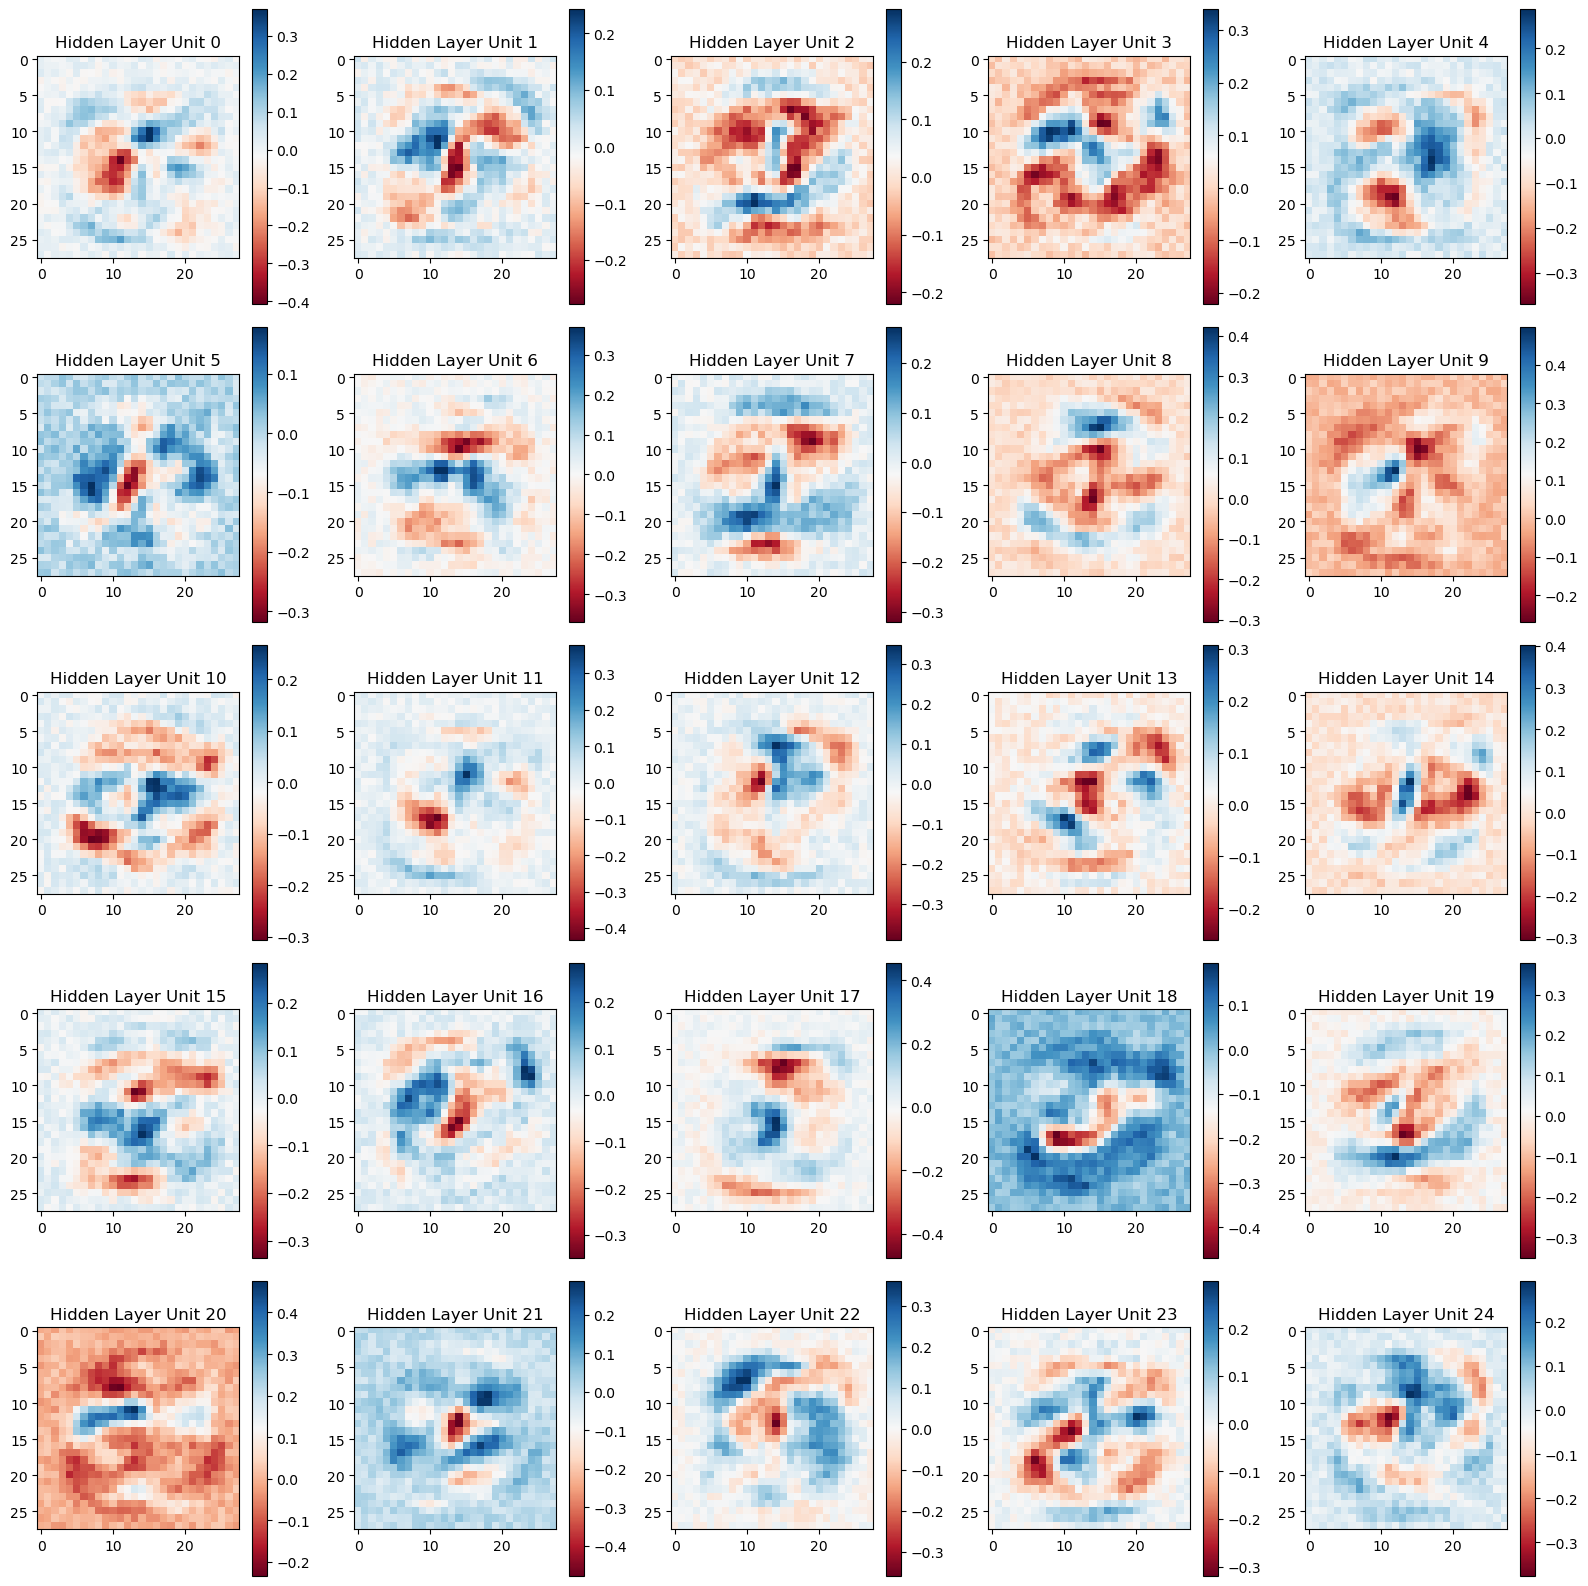

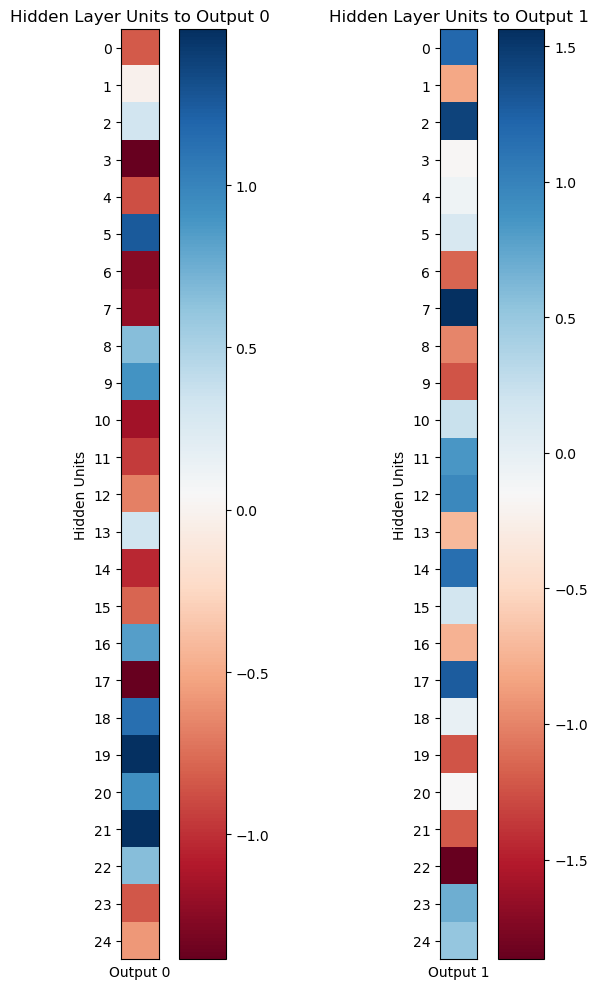

In [15]:
# num_units=25, activation=torch.sigmoid, num_epochs=50
model_25_sigmoid_50 = train_network(num_units=25, activation=torch.sigmoid, num_epochs=50)
plot_weights(model_25_sigmoid_50, output_units=[0, 1])

Training completed!
Accuracy of the model on the validation images: 92.27%


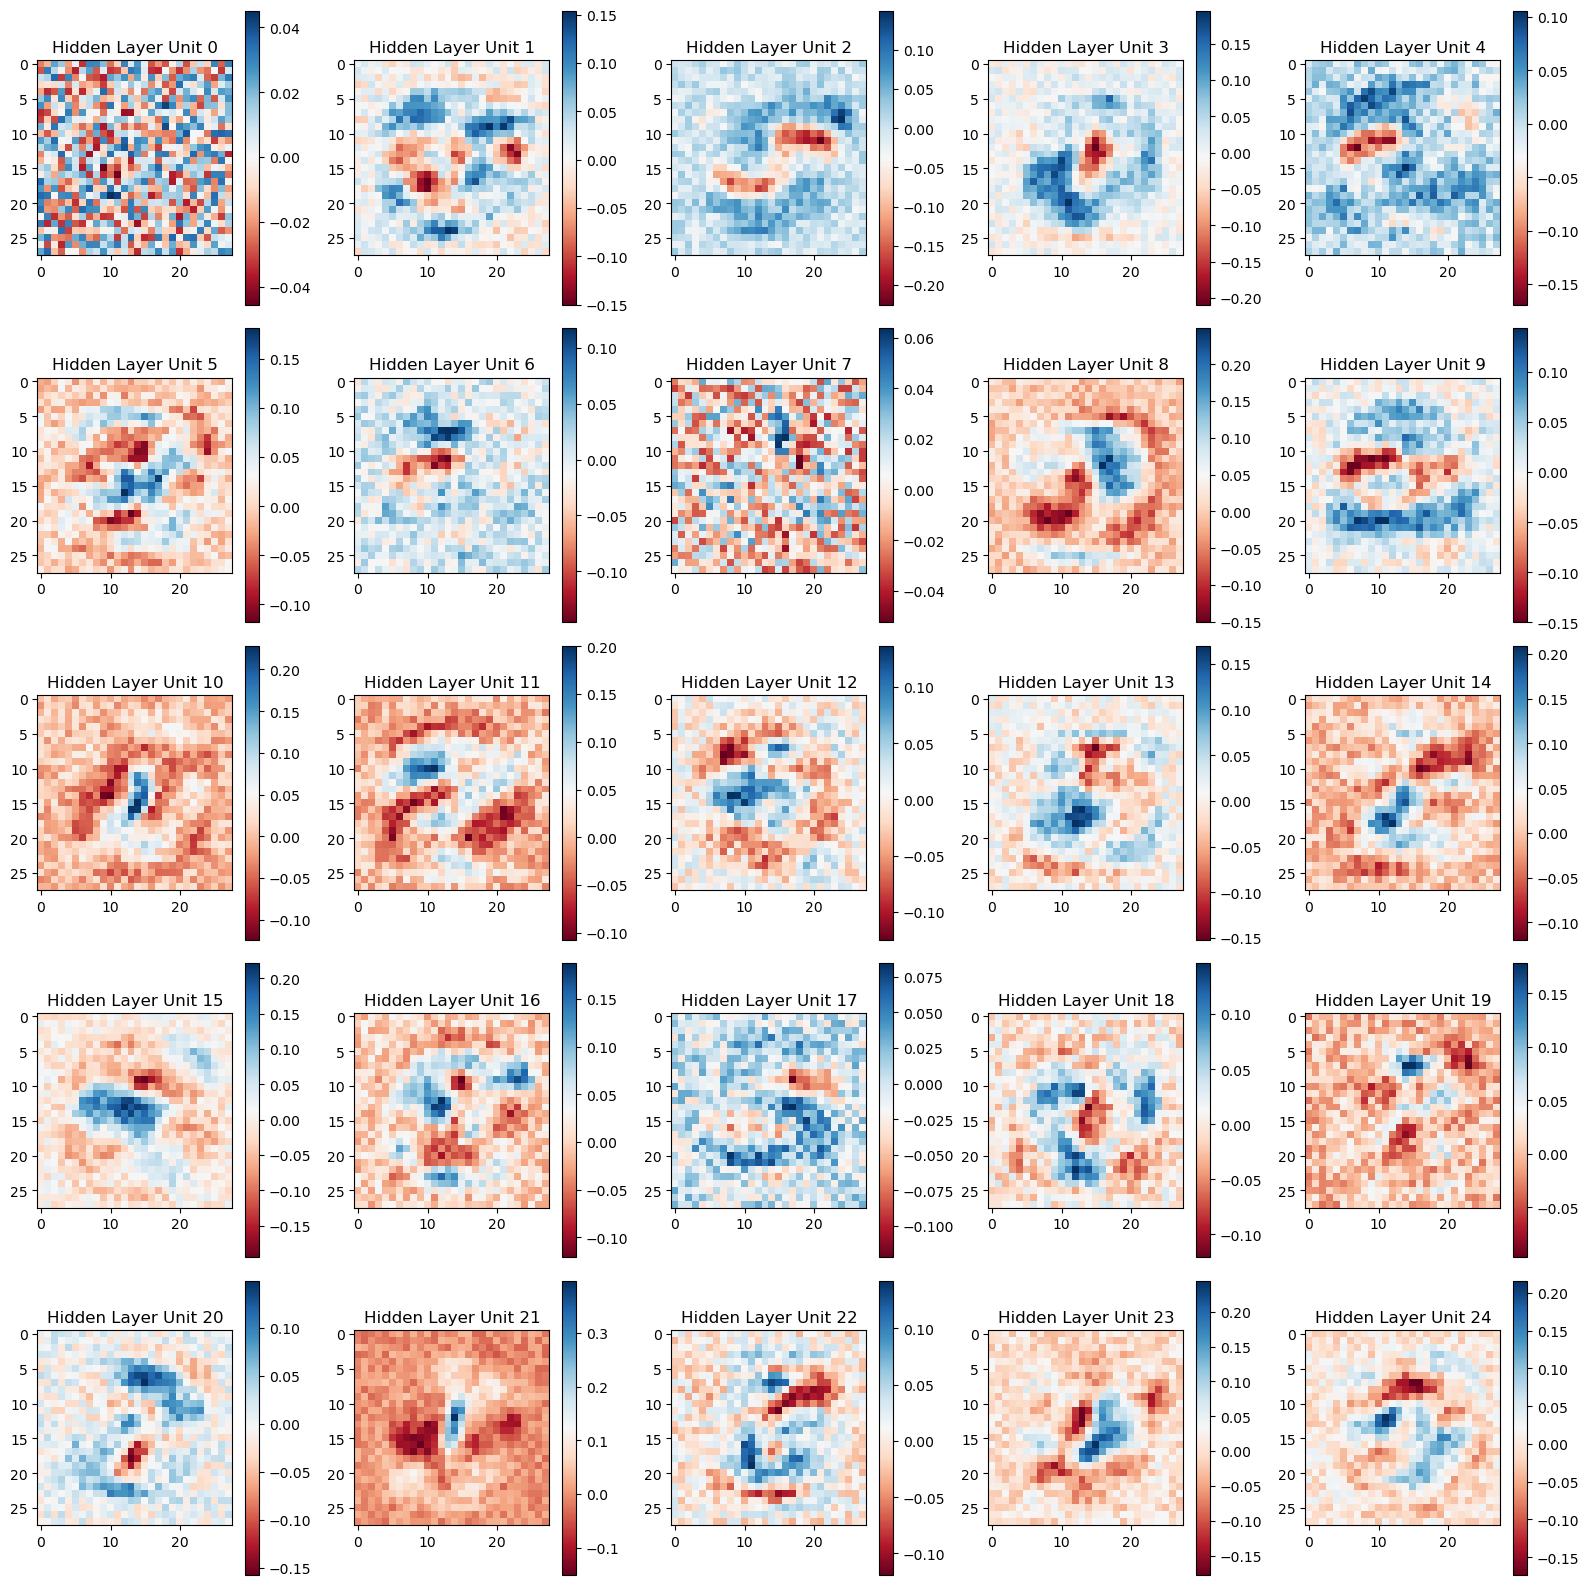

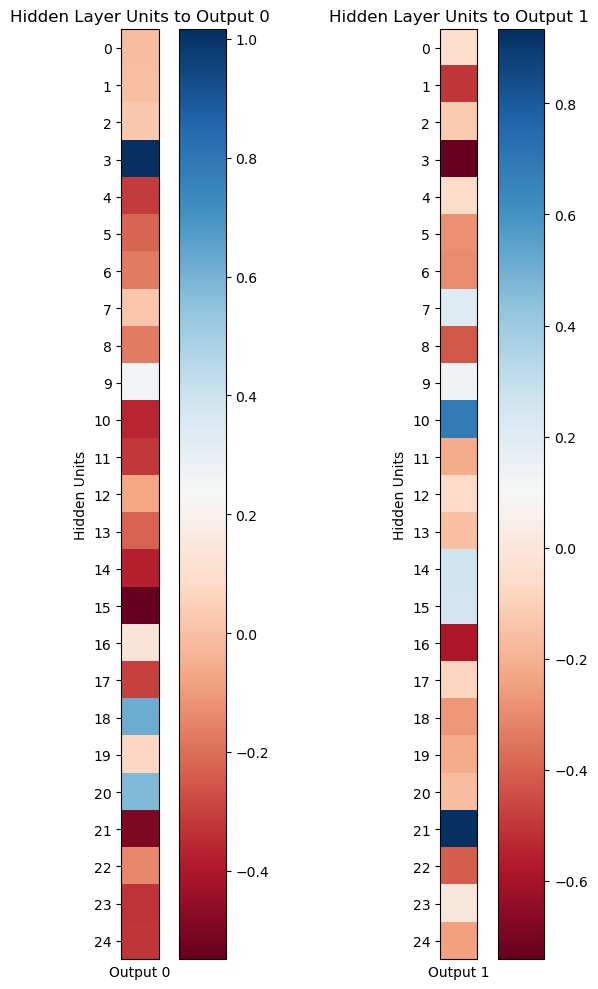

In [16]:
# num_units=25, activation=torch.nn.ReLU(), num_epochs=10
model_25_relu_10 = train_network(num_units=25, activation=torch.nn.ReLU(), num_epochs=10)
plot_weights(model_25_relu_10, output_units=[0, 1])

Training completed!
Accuracy of the model on the validation images: 95.17%


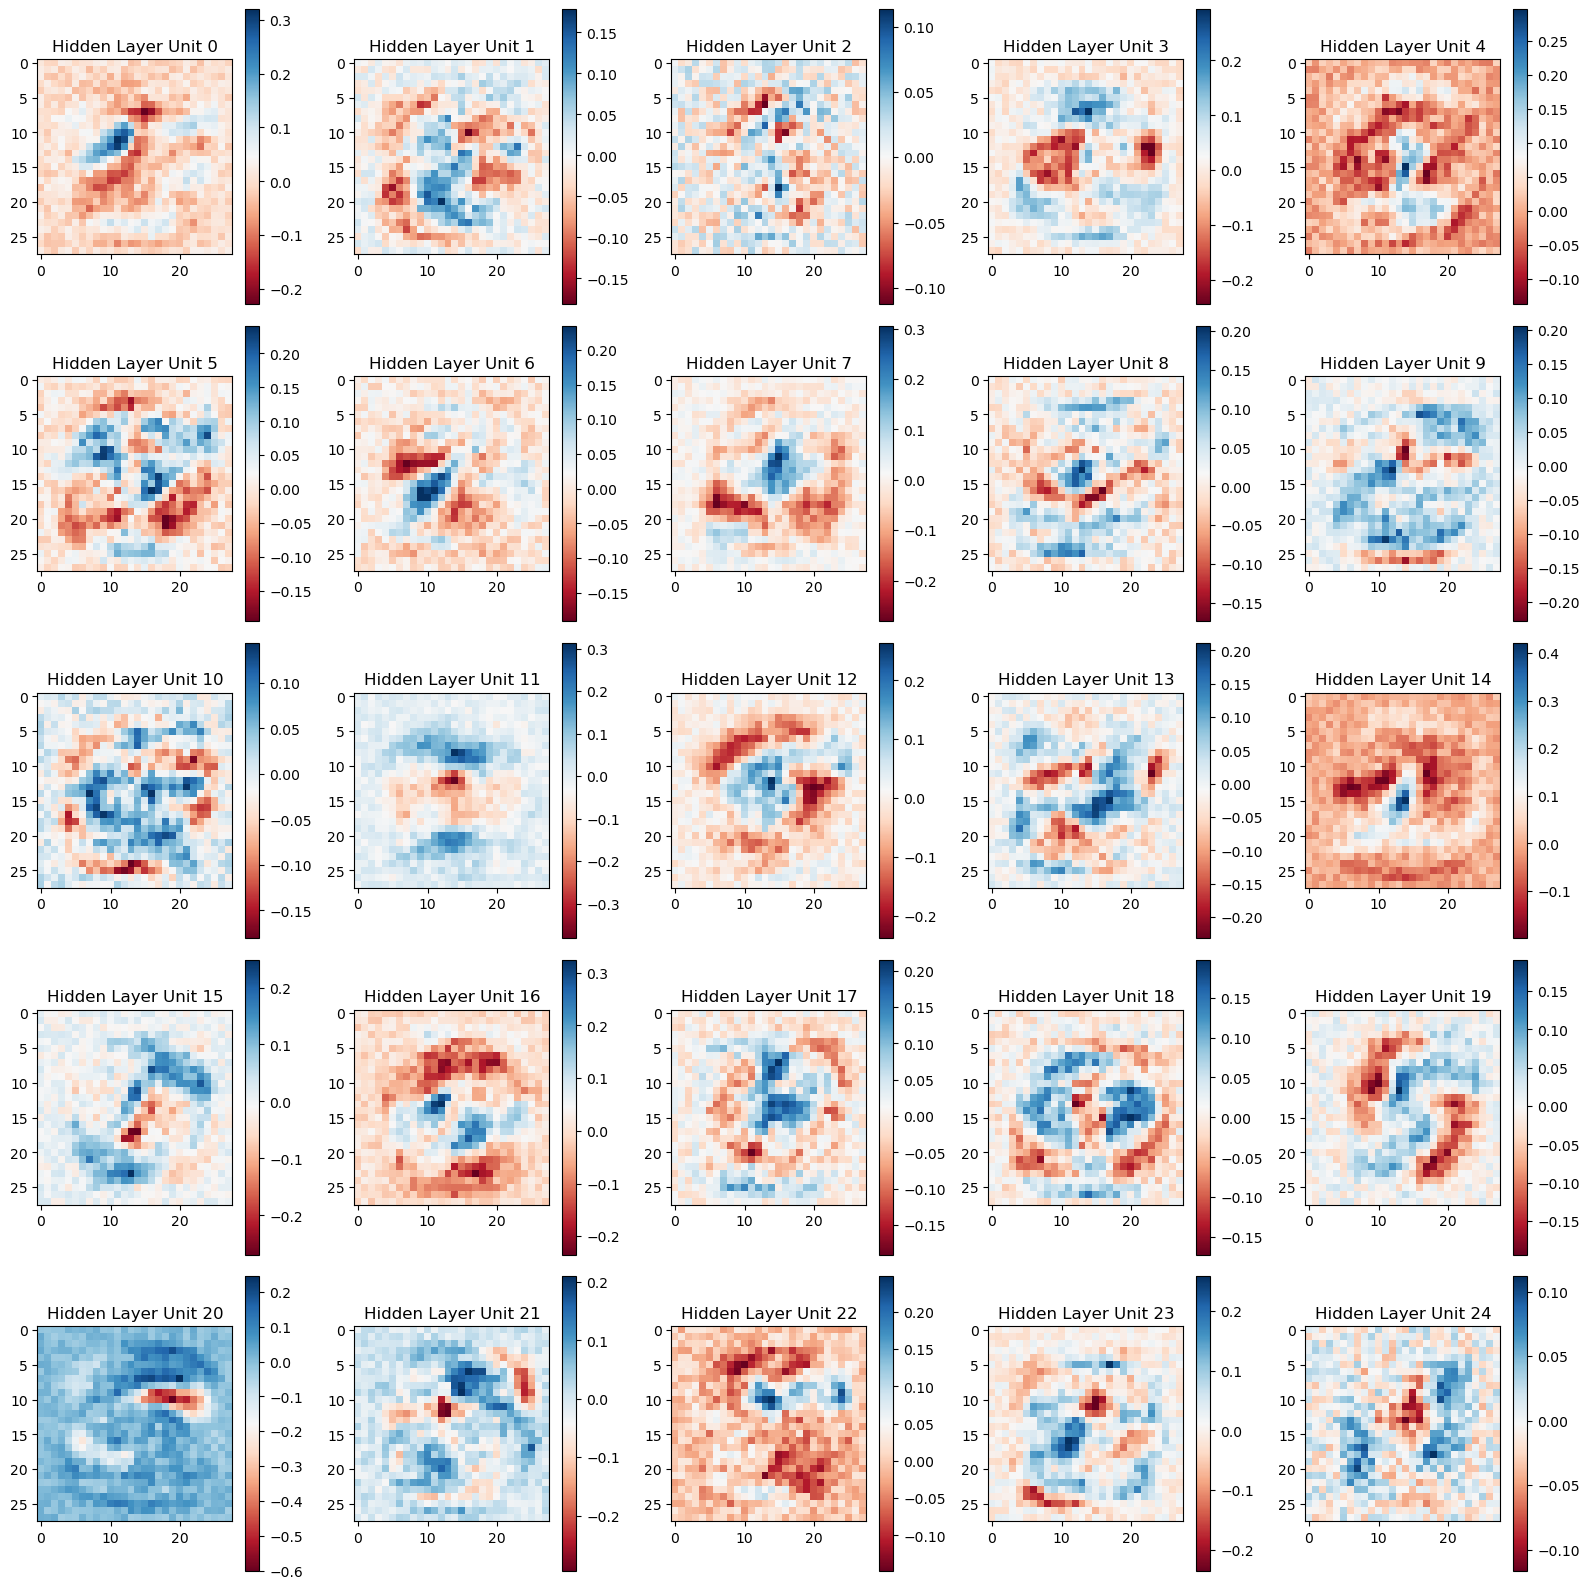

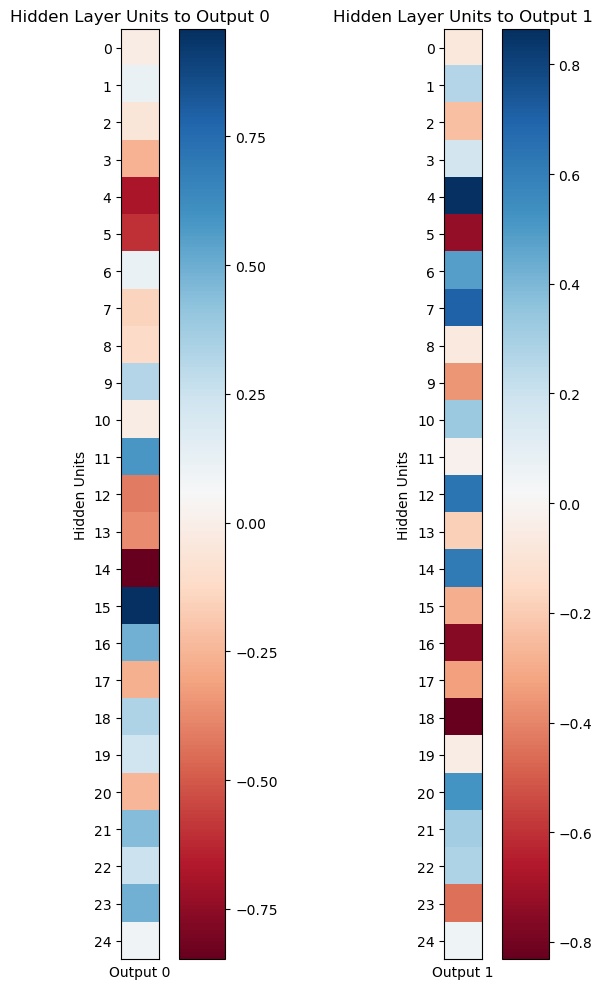

In [17]:
# num_units=25, activation=torch.nn.ReLU(), num_epochs=50
model_25_relu_50 = train_network(num_units=25, activation=torch.nn.ReLU(), num_epochs=50)
plot_weights(model_25_relu_50, output_units=[0, 1])